## PHẦN 1: CÀI ĐẶT, IMPORTS & THIẾT LẬP BAN ĐẦU

In [20]:
# ==============================================================================
# CELL 1.1: CÀI ĐẶT THƯ VIỆN & BIẾN MÔI TRƯỜNG (CẬP NHẬT)
# ==============================================================================
import os
import json
import asyncio
import operator
import time 
import re
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional, Union

# Tải các biến môi trường
from dotenv import load_dotenv 
load_dotenv()

# LangChain & LangGraph
from langchain_core.messages import BaseMessage, HumanMessage   
from pydantic.v1 import BaseModel, Field, schema_json_of
# --- NÂNG CẤP: Chuyển sang thư viện Google Generative AI (dành cho AI Studio) ---
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages

# --- NÂNG CẤP: Thêm công cụ tìm kiếm ---
from langchain_community.tools.tavily_search import TavilySearchResults

# Thư viện hỗ trợ & Kho tri thức
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from rich.console import Console
from rich.markdown import Markdown
from rich.pretty import pprint
from IPython.display import Image, display

In [21]:
# ==============================================================================
# CELL 1.2: CẤU HÌNH LOG & CÁC HÀM IN ẤN
# ==============================================================================
from langchain_groq import ChatGroq
# --- CẤU HÌNH LOG ---
VERBOSE_MODE = True

# --- KHỞI TẠO CÁC CÔNG CỤ IN ẤN ---
console = Console()

def print_step(message: str):
    if VERBOSE_MODE:
        console.print(f"\n[bold cyan]>[/bold cyan] {message}")

def print_result(data: Any, title: str = "Kết quả"):
    if VERBOSE_MODE:
        console.print(f"[bold green]✔️ {title}:[/bold green]")
        pprint(data, expand_all=True)
        
def print_warning(message: str):
    if VERBOSE_MODE:
        console.print(f"[bold yellow]⚠️  {message}[/bold yellow]")

In [22]:
# ==============================================================================
# CELL 1.3: KHỞI TẠO LLM (NÂNG CẤP SANG GOOGLE AI STUDIO)
# ==============================================================================
try:
    llm = ChatGoogleGenerativeAI(
        model="gemini-2.5-flash", # Sử dụng model mới nhất và mạnh nhất
        temperature=0.1,
        google_api_key=os.getenv("GOOGLE_API_KEY")
    )
    print("✅ LLM (Gemini 2.5 Flash từ Google AI Studio) đã được khởi tạo thành công.")
except Exception as e:
    print(f"❌ LỖI: Không thể khởi tạo LLM. Hãy chắc chắn bạn đã cài 'langchain-google-genai' và có GOOGLE_API_KEY trong file .env. Lỗi: {e}")
    llm = None

✅ LLM (Gemini 2.5 Flash từ Google AI Studio) đã được khởi tạo thành công.


## PHẦN 2: ĐỊNH NGHĨA STATE CỦA HỆ THỐNG


In [23]:
# ==============================================================================
# CELL 1.4: TẢI KHO TRI THỨC (RAG)
# ==============================================================================
# --- TẢI KHO TRI THỨC ---
BASE_VECTOR_STORE_PATH = "vector_store"
vector_store = None
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

if os.path.exists(BASE_VECTOR_STORE_PATH):
    subdirectories = [f.path for f in os.scandir(BASE_VECTOR_STORE_PATH) if f.is_dir()]
    if not subdirectories:
        print(f"❌ LỖI: Không tìm thấy thư mục con nào trong '{BASE_VECTOR_STORE_PATH}'.")
    else:
        try:
            print_step(f"Đang tải và hợp nhất các kho tri thức từ {len(subdirectories)} thư mục...")
            # Tải kho tri thức đầu tiên để làm cơ sở
            first_store_path = subdirectories.pop(0)
            vector_store = FAISS.load_local(first_store_path, embeddings, allow_dangerous_deserialization=True)
            print(f"✅ Đã tải thành công kho tri thức cơ sở: '{os.path.basename(first_store_path)}'")

            # Hợp nhất các kho tri thức còn lại
            for store_path in subdirectories:
                if os.path.exists(os.path.join(store_path, "index.faiss")):
                    temp_store = FAISS.load_local(store_path, embeddings, allow_dangerous_deserialization=True)
                    vector_store.merge_from(temp_store)
                    print(f"✅ Đã hợp nhất thành công: '{os.path.basename(store_path)}'")
                else:
                    print_warning(f"Bỏ qua thư mục '{os.path.basename(store_path)}' vì không chứa file index.faiss.")
            
            print("\n[bold green]✔️ Tất cả các kho tri thức RAG đã được tải và hợp nhất thành công.[/bold green]")

        except Exception as e:
            print(f"❌ LỖI trong quá trình tải hoặc hợp nhất kho tri thức: {e}")
else:
    print(f"❌ LỖI: Không tìm thấy thư mục gốc của kho tri thức tại '{BASE_VECTOR_STORE_PATH}'.")


> Đang tải và hợp nhất các kho tri thức từ 2 thư mục...

✅ Đã tải thành công kho tri thức cơ sở: 'sgk_toan_12_1'
✅ Đã hợp nhất thành công: 'sgk_toan_9'

[bold green]✔️ Tất cả các kho tri thức RAG đã được tải và hợp nhất thành công.[/bold green]


In [24]:
# ==============================================================================
# CELL 1.5: KHỞI TẠO VÀ QUẢN LÝ TRÍ NHỚ DÀI HẠN (NÂNG CẤP V9.4)
# ==============================================================================
MEMORY_FILE_PATH = "long_term_memory.json"
memory_vector_store = None

# Hàm để tải trí nhớ từ file JSON
def load_memory():
    if not os.path.exists(MEMORY_FILE_PATH):
        return []
    with open(MEMORY_FILE_PATH, 'r', encoding='utf-8') as f:
        return json.load(f)

# Hàm để lưu một giáo án mới vào trí nhớ
def save_to_memory(request: str, structured_plan: Dict[str, Any]):
    memory = load_memory()
    memory.append({
        "request": request,
        "plan": structured_plan
    })
    with open(MEMORY_FILE_PATH, 'w', encoding='utf-8') as f:
        json.dump(memory, f, ensure_ascii=False, indent=2)
    print_step("🧠 Đã lưu giáo án thành công vào Trí nhớ Dài hạn.")

# Hàm để tạo một vector store từ trí nhớ (để tìm kiếm tương đồng)
def build_memory_vector_store():
    global memory_vector_store
    memory_content = load_memory()
    if not memory_content:
        print_warning("Trí nhớ trống, không có gì để xây dựng vector store.")
        return

    # Chỉ lấy phần 'request' để tìm kiếm
    texts = [item['request'] for item in memory_content]
    # Lưu toàn bộ item làm metadata
    metadatas = memory_content
    
    memory_vector_store = FAISS.from_texts(texts, embeddings, metadatas=metadatas)
    print_step("✅ Đã xây dựng Vector Store cho Trí nhớ Dài hạn.")

# Tự động xây dựng vector store khi khởi động notebook
build_memory_vector_store()

> ✅ Đã xây dựng Vector Store cho Trí nhớ Dài hạn.

In [25]:
# ==============================================================================
# CELL 2.1: ĐỊNH NGHĨA STATE NÂNG CAO (v9.0)
# ==============================================================================
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional, Union
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
import operator

# --- Hàm tiện ích (giữ nguyên) ---
def merge_dicts(dict1: Dict[str, Any], dict2: Dict[str, Any]) -> Dict[str, Any]:
    merged = dict1.copy()
    for key, value in dict2.items():
        if key in merged and isinstance(merged[key], dict) and isinstance(value, dict):
            merged[key] = merge_dicts(merged[key], value)
        else:
            merged[key] = value
    return merged

# --- Cấu trúc dữ liệu con (giữ nguyên) ---
class DetailedTask(TypedDict):
    task_id: int
    task_name: str
    task_description: str
    estimated_duration: int 
    status: Literal["pending", "completed"]

# === NÂNG CẤP V9.0: CÁC CẤU TRÚC DỮ LIỆU MỚI CHO TƯ DUY SÂU ===
class DifferentiatedInstruction(TypedDict):
    """Gợi ý cho việc dạy học phân hóa trong một hoạt động."""
    for_struggling_students: str
    for_advanced_students: str

class StructuredContentItem(TypedDict):
    """Định nghĩa một hoạt động hoặc đánh giá có cấu trúc."""
    task_id: int
    activity_name: str
    question_or_description: str # Gộp 'question' và 'description'
    duration_minutes: int
    content_type: str # Gộp 'activity_type' và 'question_type'
    teacher_actions: List[str]
    solution_guide: Any
    answer: Optional[str] # Dành cho câu hỏi đánh giá
    differentiation: Optional[DifferentiatedInstruction]

class FinalStructuredPlan(TypedDict):
    """Định nghĩa cấu trúc JSON cho giáo án cuối cùng."""
    general_info: Dict[str, Any]
    learning_objectives: List[str]
    preparation: Dict[str, List[str]]
    knowledge_summary: str
    lesson_flow: List[StructuredContentItem]
    # pedagogical_explainer: Dict[str, Any] # Dành cho nâng cấp tương lai

# === NÂNG CẤP V9.0: STATE MỚI VỚI CÁC TRƯỜNG TRÍ TUỆ MỚI ===
class TeacherStateV5(TypedDict):
    # Các trường cơ bản
    original_request: str
    messages: Annotated[List[BaseMessage], add_messages]
    domain: Optional[str]
    
    # === NÂNG CẤP: student_persona giờ sẽ chứa cả chiến lược phân hóa ===
    student_persona: Optional[Dict[str, Any]] 
    
    # Các bước tuần tự ban đầu
    analyzed_objective: Optional[Any]
    pedagogy_strategy: Optional[Any]
    pedagogical_blueprint: Optional[List[str]]

    # Các trường nâng cao
    expanded_queries: Optional[List[str]]
    task_list: Optional[List[DetailedTask]]
    current_task_id: Optional[int]
    reflection_notes: Optional[str]
    agent_outputs: Annotated[Dict[str, Any], merge_dicts] 
    next_agent: str
    
    # Các trường tạm thời cho vòng lặp kiểm duyệt vi mô (Micro-loop)
    current_content_to_validate: Optional[Dict[str, Any]]
    validation_feedback: Optional[str]

    inspirational_example: Optional[List[Dict[str, Any]]]

    # === NÂNG CẤP: Output cuối cùng sẽ có 2 dạng ===
    final_structured_plan: Optional[FinalStructuredPlan] # Dạng JSON có cấu trúc
    final_markdown_plan: Optional[str] # Dạng Markdown để hiển thị

print("✅ 'TeacherStateV5' (v9.0 - Hỗ trợ Phân hóa & Cấu trúc) đã được định nghĩa.")

✅ 'TeacherStateV5' (v9.0 - Hỗ trợ Phân hóa & Cấu trúc) đã được định nghĩa.


In [26]:
# ==============================================================================
# CELL 2.2: NODE KHỞI TẠO STATE
# ==============================================================================
def initialize_state_node(state: TeacherStateV5) -> Dict[str, Any]:
    """
    Node đầu tiên trong graph.
    Lấy yêu cầu gốc từ tin nhắn đầu vào và điền vào trường 'original_request'.
    """
    print_step("`Initializer`: Đang khởi tạo trạng thái và lấy yêu cầu gốc...")
    user_request = state['messages'][-1].content
    return {"original_request": user_request}

print("✅ Node khởi tạo 'initialize_state_node' đã được định nghĩa.")

✅ Node khởi tạo 'initialize_state_node' đã được định nghĩa.


## PHẦN 3: ĐỊNH NGHĨA CÁC AGENT

In [27]:
# ==============================================================================
# CELL 3.1: HÀM TIỆN ÍCH & CẤU TRÚC DỮ LIỆU (v9.7 - TƯ DUY LINH HOẠT)
# ==============================================================================
import json
from pydantic.v1 import BaseModel, Field, schema_json_of
from typing import List, Dict, Any, Literal, Optional

# --- Các hàm tiện ích giữ nguyên ---
def format_solution_guide(guide: Any) -> str:
    if not guide: return "Chưa có hướng dẫn."
    if isinstance(guide, str): return guide
    if isinstance(guide, list): return "\n".join(f"- {step}" for step in guide)
    if isinstance(guide, dict): return "\n".join(f"- {key.replace('_', ' ').title()}: {value}" for key, value in guide.items())
    return str(guide)

def format_teacher_actions(actions: Optional[List[str]]) -> str:
    if not actions: return "Giáo viên quan sát và hỗ trợ chung."
    return "\n".join(f"  - {action}" for action in actions)

def update_agent_outputs(state: "TeacherStateV5", key: str, value: Any) -> Dict[str, Any]:
    outputs = state.get("agent_outputs", {}).copy()
    if key not in outputs: outputs[key] = []
    outputs[key].append(value)
    return {"agent_outputs": outputs}

SYSTEM_PERSONA_PROMPT = "BẠN LÀ MỘT TRỢ LÝ AI CHUYÊN NGHIỆP, ĐÓNG VAI TRÒ MỘT GIÁO VIÊN GIÀU KINH NGHIỆM TẠI VIỆT NAM. LUÔN LUÔN trả lời bằng TIẾNG VIỆT."

# === CẬP NHẬT CẤU TRÚC HOẠT ĐỘNG LINH HOẠT ===
class DifferentiatedInstructionModel(BaseModel):
    for_struggling_students: str = Field(description="Gợi ý cụ thể cho nhóm học sinh yếu/gặp khó khăn.")
    for_advanced_students: str = Field(description="Gợi ý, thử thách hoặc hoạt động nâng cao cho nhóm học sinh giỏi.")

class LearningActivity(BaseModel):
    activity_name: str = Field(description="Tên của hoạt động học tập.")
    activity_type: str = Field(description="Phân loại hoạt động. Ví dụ: 'Thảo luận nhóm', 'Thực hành cá nhân'")
    duration_minutes: int = Field(description="Tổng thời gian ước tính (bằng SỐ PHÚT) cho cả hai phần.")
    teacher_actions: List[str] = Field(description="Danh sách các hành động CỤ THỂ của GIÁO VIÊN.")
    # Thay 'description' bằng cấu trúc Lõi/Mở rộng
    core_component: str = Field(description="Mô tả phần hoạt động CỐT LÕI mà TẤT CẢ học sinh cần hoàn thành.")
    extension_component: Optional[str] = Field(description="Mô tả phần hoạt động MỞ RỘNG dành cho học sinh làm nhanh hoặc nếu còn dư thời gian.")
    solution_guide: Optional[Any] = Field(description="Hướng dẫn giải hoặc các câu hỏi gợi mở.")
    differentiation: Optional[DifferentiatedInstructionModel] = Field(description="Gợi ý phân hóa cụ thể cho hoạt động này.")

class AssessmentItem(BaseModel):
    activity_name: str = Field(description="Tên của hoạt động đánh giá.")
    question_type: str = Field(description="Loại câu hỏi. Ví dụ: 'Tự luận', 'Trắc nghiệm'")
    duration_minutes: int = Field(description="Tổng thời gian ước tính (bằng SỐ PHÚT) cho cả hai phần.")
    teacher_actions: List[str] = Field(description="Danh sách các hành động CỤ THỂ của GIÁO VIÊN.")
    # Thay 'question' bằng cấu trúc Lõi/Mở rộng
    core_component: str = Field(description="Nội dung câu hỏi hoặc đề bài CỐT LÕI mà TẤT CẢ học sinh cần hoàn thành.")
    extension_component: Optional[str] = Field(description="Câu hỏi phụ hoặc thử thách MỞ RỘNG dành cho học sinh làm nhanh hoặc nếu còn dư thời gian.")
    answer: str = Field(description="Đáp án chính xác và ngắn gọn cho phần CỐT LÕI.")
    solution_guide: Any = Field(description="Hướng dẫn giải chi tiết từng bước.")
    differentiation: Optional[DifferentiatedInstructionModel] = Field(description="Gợi ý phân hóa cụ thể cho hoạt động này.")

# --- Các model khác giữ nguyên ---
class StudentPersona(BaseModel):
    learning_pace: Literal["nhanh", "trung bình", "chậm"] = Field(description="Tốc độ học tập chung của lớp.")
    engagement_style: Literal["chủ động", "thụ động", "hỗn hợp"] = Field(description="Mức độ tham gia chung của lớp.")
    special_notes: str = Field(description="Tóm tắt các đặc điểm nổi bật của lớp học.")

class StudentPersonaAndDifferentiation(StudentPersona):
    differentiation_strategy: DifferentiatedInstructionModel = Field(description="Chiến lược dạy học phân hóa tổng thể cho cả bài học dựa trên các đặc điểm của lớp.")

class DetailedTaskModel(BaseModel):
    task_name: str = Field(description="Tên của nhiệm vụ này.")
    task_description: str = Field(description="Mô tả chi tiết nhiệm vụ cần thực hiện.")
    estimated_duration: int = Field(description="Thời gian ước tính (bằng phút) cho nhiệm vụ này.")

class TaskListWithDuration(BaseModel):
    tasks: List[DetailedTaskModel]

class DetailedPedagogyChoice(BaseModel):
    name: str = Field(description="Tên của phương pháp sư phạm được chọn.")
    rationale: str = Field(description="Lý do tại sao phương pháp này phù hợp.")
    key_actions: List[str] = Field(description="Danh sách các hành động/hoạt động cốt lõi đặc trưng cho phương pháp này.")

class ValidationResult(BaseModel):
    is_valid: bool = Field(description="Nội dung có hợp lệ và chính xác về mặt chuyên môn không.")
    feedback: str = Field(description="Phản hồi chi tiết. Nếu không hợp lệ, hãy giải thích rõ ràng lỗi sai và gợi ý cách sửa.")
    suggested_duration: Optional[int] = Field(default=None, description="Nếu có lỗi về thời gian, hãy đề xuất một thời lượng hợp lý hơn (tính bằng SỐ PHÚT).")

class Domain(BaseModel): domain: str = Field(description="Lĩnh vực học thuật chính của yêu cầu.")
class ExpandedQueries(BaseModel): queries: List[str]
class BestSnippets(BaseModel): best_snippets: List[str]
class ParsedObjective(BaseModel): action_verb: str; bloom_level: int; topic: str; grade_level: str; duration_minutes: Optional[int]
class TaskClassification(BaseModel): agent_category: Literal["activity_designer", "theory_synthesizer", "assessment_creator"]
class BlueprintStage(BaseModel): stage_name: str; stage_objective: str; stage_direction: str
class PedagogicalBlueprint(BaseModel): blueprint: List[BlueprintStage]

print("✅ Các cấu trúc dữ liệu Pydantic (v9.7 - Hoạt động Linh hoạt) đã được định nghĩa.")

✅ Các cấu trúc dữ liệu Pydantic (v9.7 - Hoạt động Linh hoạt) đã được định nghĩa.


In [28]:
# ==============================================================================
# CELL 3.2: AGENT PHÂN TÍCH YÊU CẦU BAN ĐẦU (NÂNG CẤP V9.0)
# ==============================================================================
async def objective_interpreter_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Objective Interpreter` (v7.5) đang phân tích mục tiêu...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu của người dùng và trích xuất các thông tin sau.\n**YÊU CẦU:** \"{state['original_request']}\"\n**CÁC TRƯỜNG CẦN TRÍCH XUẤT:** `action_verb`, `bloom_level` (SỐ NGUYÊN), `topic`, `grade_level`, `duration_minutes`.\n**CHỈ TRẢ VỀ JSON.**"
    structured_llm = llm.with_structured_output(ParsedObjective, method="json_mode")
    try:
        parsed_result = await structured_llm.ainvoke(prompt)
        analyzed_objective_dict = parsed_result.dict()
        analyzed_objective_dict['constraints'] = {'duration_minutes': parsed_result.duration_minutes}
        del analyzed_objective_dict['duration_minutes']
        print_result(analyzed_objective_dict, "Mục tiêu & Ràng buộc đã phân tích")
        return {"analyzed_objective": analyzed_objective_dict}
    except Exception as e:
        print_warning(f"Lỗi tại Objective Interpreter: {e}. Sử dụng mục tiêu mặc định.")
        return {"analyzed_objective": { "action_verb": "soạn", "bloom_level": 3, "topic": state['original_request'], "grade_level": "9", "constraints": {"duration_minutes": 90} }}

async def domain_classifier_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Domain Classifier` (v7.5) đang xác định lĩnh vực chuyên môn...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu của người dùng và xác định lĩnh vực học thuật chính.\n**YÊU CẦU:** \"{state['original_request']}\"\n**LĨNH VỰC CÓ THỂ CHỌN:** 'Toán học', 'Vật lý', 'Hóa học', 'Sinh học', 'Văn học', 'Lịch sử', 'Địa lý', 'Ngoại ngữ', 'Tin học'.\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `domain`."
    structured_llm = llm.with_structured_output(Domain, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.domain, "Lĩnh vực chuyên môn được xác định")
        return {"domain": result.domain}
    except Exception as e:
        print_warning(f"Lỗi tại Domain Classifier: {e}. Sử dụng lĩnh vực mặc định 'Toán học'.")
        return {"domain": "Toán học"}

# === NÂNG CẤP: Agent này giờ đây là một nhà tư vấn chiến lược ===
# === SỬA LỖI PARSING: Prompt được làm rõ ràng hơn về cấu trúc lồng nhau ===
async def differentiated_instruction_advisor_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Differentiated Instruction Advisor` (v9.1) đang phân tích và đề xuất chiến lược phân hóa...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một chuyên gia sư phạm, chuyên về dạy học phân hóa.
    **NHIỆM VỤ:** Phân tích mô tả về lớp học dưới đây và đề xuất một chiến lược dạy học phân hóa TỔNG THỂ cho cả buổi học.
    **YÊU CẦU CỦA GIÁO VIÊN:** "{state['original_request']}"
    
    **CÁC BƯỚC SUY LUẬN (BẮT BUỘC):**
    1.  **Phân tích Đặc điểm:** Dựa vào các từ khóa, hãy xác định `learning_pace`, `engagement_style`, và tóm tắt vào `special_notes`.
    2.  **Đề xuất Chiến lược Phân hóa:** Dựa trên phân tích trên, hãy điền vào đối tượng `differentiation_strategy`. Đây PHẢI là một đối tượng JSON có 2 trường sau:
        -   `for_struggling_students`: Một chiến lược cụ thể để **hỗ trợ** nhóm học sinh có thể gặp khó khăn. (Ví dụ: "Chia nhỏ nhiệm vụ, cung cấp phiếu bài tập có gợi ý công thức, cho phép thêm thời gian.")
        -   `for_advanced_students`: Một chiến lược cụ thể để **thử thách** nhóm học sinh khá giỏi. (Ví dụ: "Chuẩn bị các câu hỏi mở rộng 'Tại sao?' và 'Nếu... thì sao?', giao một bài toán ứng dụng thực tế nhỏ.")

    **YÊU CẦU ĐỊNH DẠNG:** BẮT BUỘC trả về một đối tượng JSON duy nhất tuân thủ schema `StudentPersonaAndDifferentiation`. Trường `differentiation_strategy` PHẢI là một object lồng vào bên trong.
    """
    structured_llm = llm.with_structured_output(StudentPersonaAndDifferentiation, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.dict(), "Hồ sơ lớp học và Chiến lược Phân hóa")
        return {"student_persona": result.dict()}
    except Exception as e:
        print_warning(f"Lỗi tại Differentiated Instruction Advisor: {e}. Sử dụng hồ sơ mặc định.")
        fallback_persona = {
            "learning_pace": "trung bình",
            "engagement_style": "hỗn hợp",
            "special_notes": "Không có ghi chú đặc biệt.",
            "differentiation_strategy": {
                "for_struggling_students": "Quan sát và hỗ trợ thêm khi cần thiết.",
                "for_advanced_students": "Khuyến khích các em tìm tòi thêm."
            }
        }
        return {"student_persona": fallback_persona}

print("✅ Các agent phân tích yêu cầu ban đầu (v9.0 - Hỗ trợ Phân hóa) đã sẵn sàng.")

✅ Các agent phân tích yêu cầu ban đầu (v9.0 - Hỗ trợ Phân hóa) đã sẵn sàng.


In [29]:
# ==============================================================================
# CELL 3.3: AGENT LẬP KẾ HOẠCH CHIẾN LƯỢC (v7.5)
# ==============================================================================
async def pedagogy_strategist_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Pedagogy Strategist` (v7.5) đang xây dựng chiến lược sư phạm chi tiết...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **MỤC TIÊU BÀI HỌC:** {state.get('analyzed_objective')}
    **HỒ SƠ LỚP HỌC:** {state.get('student_persona')}
    **NHIỆM VỤ:** Dựa vào mục tiêu và hồ sơ lớp học, hãy chọn MỘT phương pháp sư phạm phù hợp nhất. Sau đó, phân tích phương pháp đó thành các hành động cốt lõi.
    **VÍ DỤ:** Nếu chọn 'Dạy học theo dự án', key_actions có thể là ["Giao dự án", "Học sinh làm việc nhóm", "Báo cáo sản phẩm"].
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với các key `name`, `rationale`, `key_actions`.
    """
    structured_llm = llm.with_structured_output(DetailedPedagogyChoice, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.dict(), "Chiến lược sư phạm chi tiết")
        return {"pedagogy_strategy": result.dict()}
    except Exception as e:
        print_warning(f"Lỗi tại Pedagogy Strategist: {e}. Sử dụng chiến lược mặc định.")
        return {"pedagogy_strategy": {"name": "Dạy học giải quyết vấn đề", "rationale": "Mặc định do lỗi.", "key_actions": ["Nêu vấn đề", "Học sinh tìm giải pháp", "Trình bày kết quả"]}}

async def pedagogical_architect_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Pedagogical Architect` (v9.4) đang thiết kế kịch bản buổi học...")
    
    inspirational_example = state.get("inspirational_example")
    example_prompt_part = ""
    if inspirational_example:
        example_prompt_part = f"""
        **VÍ DỤ THAM KHẢO (TỪ MỘT GIÁO ÁN THÀNH CÔNG TRƯỚC ĐÂY):**
        Đây là một luồng hoạt động đã được chứng minh là hiệu quả cho một chủ đề tương tự. Hãy học hỏi cấu trúc và cách tiếp cận từ nó:
        ```json
        {json.dumps(inspirational_example, ensure_ascii=False, indent=2)}
        ```
        """
    
    prompt = f"""{SYSTEM_PERSONA_PROMPT} Với vai trò là một chuyên gia thiết kế trải nghiệm học tập.
    **NHIỆM VỤ:** Xây dựng một "Bản thiết kế Sư phạm" - một kịch bản CẤP CAO cho buổi học.
    
    {example_prompt_part}
    **QUY TẮC:**
    1.  Tạo ra 3-5 giai đoạn chính cho dòng chảy của buổi học.
    2.  Mỗi giai đoạn phải có tên (`stage_name`), mục tiêu (`stage_objective`), và định hướng (`stage_direction`).
    3.  Đảm bảo độ khó tăng tiến qua các giai đoạn.
    **THÔNG TIN PHÂN TÍCH:**
    - Mục tiêu: {state.get('analyzed_objective')}
    - Hồ sơ lớp học: {state.get('student_persona')}
    - Chiến lược Sư phạm: {state.get('pedagogy_strategy')}
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key là `blueprint`, giá trị là một danh sách các đối tượng Stage.
    """
    structured_llm = llm.with_structured_output(PedagogicalBlueprint, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        blueprint_list_of_strings = [f"{stage.stage_name}: {stage.stage_direction}" for stage in result.blueprint]
        print_result(blueprint_list_of_strings, "Bản thiết kế Sư phạm đã được tạo")
        return {"pedagogical_blueprint": blueprint_list_of_strings}
    except Exception as e:
        print_warning(f"Lỗi tại Pedagogical Architect: {e}. Sử dụng blueprint mặc định.")
        return {"pedagogical_blueprint": ["Giai đoạn 1: Giới thiệu bài học", "Giai đoạn 2: Luyện tập", "Giai đoạn 3: Đánh giá"]}

async def memory_retrieval_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Memory Retrieval` (v9.4) đang tìm kiếm trong trí nhớ...")
    
    if not memory_vector_store:
        print_warning("Không có Trí nhớ Dài hạn. Bỏ qua bước này.")
        return {"inspirational_example": None}

    user_request = state["original_request"]
    
    # Tìm kiếm 1 ví dụ tương đồng nhất trong trí nhớ
    try:
        results = memory_vector_store.similarity_search_with_score(user_request, k=1)
        if results and results[0][1] < 0.5: # Chỉ lấy nếu độ tương đồng cao (điểm score thấp là tốt)
            best_example = results[0][0].metadata
            print_result(best_example['request'], "Tìm thấy ví dụ tương đồng trong trí nhớ")
            # Chỉ trả về phần "lesson_flow" để làm ví dụ
            return {"inspirational_example": best_example['plan']['lesson_flow']}
        else:
            print_step("Không tìm thấy ví dụ nào đủ tương đồng trong trí nhớ.")
            return {"inspirational_example": None}
    except Exception as e:
        print_warning(f"Lỗi khi truy xuất trí nhớ: {e}")
        return {"inspirational_example": None}
    
print("✅ Các agent lập kế hoạch chiến lược đã sẵn sàng.")

✅ Các agent lập kế hoạch chiến lược đã sẵn sàng.


In [30]:
# ==============================================================================
# CELL 3.4: AGENT TRUY XUẤT VÀ TỔNG HỢP KIẾN THỨC (RAG) (v7.5)
# ==============================================================================
async def query_expansion_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Query Expansion` (v7.5) đang phân tích yêu cầu...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Tạo ra các cụm từ tìm kiếm đa dạng bằng tiếng Việt để tìm tài liệu.\n**CHỦ ĐỀ:** \"{state.get('analyzed_objective', {}).get('topic', '')}\"\n**LĨNH VỰC:** {state.get('domain', 'Chung')}\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `queries`."
    structured_llm = llm.with_structured_output(ExpandedQueries, method="json_mode")
    try:
        response = await structured_llm.ainvoke(prompt)
        print_result(response.queries, "Các truy vấn tìm kiếm đã được mở rộng")
        return {"expanded_queries": response.queries}
    except Exception as e:
        print_warning(f"Lỗi tại Query Expansion: {e}. Sử dụng truy vấn gốc.")
        return {"expanded_queries": [state.get('analyzed_objective', {}).get('topic', '')]}

async def resource_scout_agent_v2(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Resource Scout` (v8.1 - Sửa lỗi) đang tìm kiếm và sàng lọc...")
    retriever = vector_store.as_retriever(search_kwargs={"k": 5})
    all_docs = []
    queries = state.get('expanded_queries', [state.get('analyzed_objective', {}).get('topic', '')])
    for query in queries:
        all_docs.extend(retriever.invoke(query))
    unique_docs_content = list({doc.page_content for doc in all_docs})[:8]
    print_step(f"Tìm thấy {len(all_docs)} tài liệu, sàng lọc còn {len(unique_docs_content)} đoạn văn bản độc nhất.")
    
    # --- Phần Re-ranker giữ nguyên ---
    rerank_prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu gốc và chọn ra 3-4 đoạn văn bản tiếng Việt phù hợp NHẤT từ danh sách dưới đây.\n**YÊU CẦU GỐC:** \"{state.get('original_request', '')}\"\n**DANH SÁCH TÀI LIỆU:** {json.dumps(unique_docs_content, ensure_ascii=False)}\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `best_snippets`."
    structured_llm_reranker = llm.with_structured_output(BestSnippets, method="json_mode")
    best_snippets_text = "\n\n---\n\n".join(unique_docs_content)
    try:
        reranked_result = await structured_llm_reranker.ainvoke(rerank_prompt)
        best_snippets_text = "\n\n---\n\n".join(reranked_result.best_snippets)
    except Exception as e:
        print_warning(f"Lỗi tại Re-ranker: {e}. Sử dụng tất cả tài liệu.")

    # === ĐẠI TU PROMPT TÓM TẮT ===
    summary_prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một chuyên gia tổng hợp thông tin.
    **NHIỆM VỤ DUY NHẤT:** Dựa **CHỈ** vào các đoạn văn bản dưới đây, hãy viết một bản **TÓM TẮT KIẾN THỨC CỐT LÕI** về chủ đề "{state.get('analyzed_objective', {}).get('topic', '')}".

    **QUY TẮC TUYỆT ĐỐI:**
    1.  **CHỈ DÙNG THÔNG TIN ĐƯỢC CUNG CẤP:** Tuyệt đối không được bình luận về chất lượng của các đoạn văn bản. Không được "từ chối" tóm tắt.
    2.  **TỔNG HỢP & SUY LUẬN:** Nhiệm vụ của bạn là đọc tất cả các mẩu thông tin (kể cả từ các bài tập) và suy luận ra các định nghĩa, tính chất cốt lõi nhất.
    3.  **CẤU TRÚC RÕ RÀNG:** Trình bày bản tóm tắt một cách mạch lạc, có đầu mục rõ ràng (ví dụ: 1. Định nghĩa, 2. Tính chất...).
    4.  **TRẢ VỀ TÓM TẮT:** Luôn luôn trả về một bản tóm tắt, ngay cả khi nó ngắn gọn do thông tin hạn chế.

    **CÁC ĐOẠN VĂN BẢN ĐỂ TÓM TẮT:**
    {best_snippets_text}
    """
    summary = "Chưa có bản tóm tắt kiến thức."
    try:
        summary_response = await llm.ainvoke(summary_prompt)
        summary = summary_response.content
    except Exception as e:
        print_warning(f"Lỗi tại bước tóm tắt: {e}.")
        
    resource = {"source": "Sách giáo khoa (từ RAG - đã sàng lọc)", "summary": summary}
    print_result(resource, "Tài liệu RAG cuối cùng")
    return update_agent_outputs(state, "resources", resource)

print("✅ Các agent RAG đã sẵn sàng.")

✅ Các agent RAG đã sẵn sàng.


In [31]:
# ==============================================================================
# CELL 3.5: AGENT GIAO VIỆC & CHUYÊN MÔN (v12.0 - HOÀN THIỆN)
# ==============================================================================

# Plan Delegator được trang bị "kinh nghiệm sư phạm" và mệnh lệnh rõ ràng
async def plan_delegator_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Plan Delegator` (v12.0 - Nhà hoạch định Thông thái) đang triển khai...")
    
    blueprint = state.get('pedagogical_blueprint', [])
    total_duration = state.get('analyzed_objective', {}).get('constraints', {}).get('duration_minutes', 90)

    # Reset lại agent_outputs mỗi khi lập kế hoạch lại
    agent_outputs_history = state.get("agent_outputs", {})
    new_agent_outputs = {"resources": agent_outputs_history.get("resources", [])}
        
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một Nhà Hoạch định Sư phạm giàu kinh nghiệm.
    **NHIỆM VỤ:** Chuyển đổi "Bản thiết kế Sư phạm" thành một danh sách các nhiệm vụ cụ thể, với sự phân bổ thời gian THỰC TẾ và KHẢ THI.

    **BẢN THIẾT KẾ SƯ PHẠM:**
    {json.dumps(blueprint, ensure_ascii=False, indent=2)}

    **BẢNG TRA CỨU KINH NGHIỆM SƯ PHẠM (THAM KHẢO BẮT BUỘC):**
    - Khởi động/Khám phá ban đầu: ~10-15 phút.
    - Xây dựng kiến thức (mỗi khái niệm lớn): ~20-25 phút.
    - Thực hành/Hoạt động nhóm (vẽ hình, thí nghiệm): ~25-30 phút.
    - Luyện tập/Củng cố (giải bài tập): ~15-20 phút.
    - Tổng kết/Đánh giá/Giao bài tập: ~5-10 phút.

    **QUY TẮC TUYỆT ĐỐI:**
    1.  **PHÂN BỔ THỰC TẾ:** Dựa vào Bảng tra cứu kinh nghiệm, hãy phân bổ thời gian cho từng nhiệm vụ một cách hợp lý. Đặc biệt, các hoạt động khám phá và thực hành cần nhiều thời gian.
    2.  **TUÂN THỦ TỔNG THỜI GIAN:** Tổng thời lượng của tất cả các nhiệm vụ cộng lại PHẢI bằng chính xác **{total_duration} phút**.
    
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON theo schema `TaskListWithDuration`.
    """
    
    structured_llm = llm.with_structured_output(TaskListWithDuration, method="json_mode")
    
    try:
        task_list_result = await structured_llm.ainvoke(prompt)
        tasks_with_status = [{"task_id": i, **t.dict(), "status": "pending"} for i, t in enumerate(task_list_result.tasks) if t]
        
        print_result(tasks_with_status, f"Đã tạo {len(tasks_with_status)} nhiệm vụ chi tiết")
        
        return {"task_list": tasks_with_status, "reflection_notes": None, "agent_outputs": new_agent_outputs}
    
    except Exception as e:
        print_warning(f"Lỗi tại Plan Delegator: {e}. Tạo task mặc định.")
        fallback_task = { "task_id": 0, "task_name": "Hoạt động luyện tập", "task_description": "Học sinh thực hành bài tập.", "estimated_duration": 45, "status": "pending" }
        return {"task_list": [fallback_task], "reflection_notes": None, "agent_outputs": state.get("agent_outputs", {})}


# Specialist Agent với "Tư duy Kỷ luật"
async def specialist_agent_logic(state: "TeacherStateV5", agent_type: str, pydantic_model: type[BaseModel]) -> Dict[str, Any]:
    print_step(f"`Agent: {agent_type}` (v12.0) đang tạo nội dung theo kỷ luật...")
    task_to_run = next((t for t in state.get('task_list', []) if t['task_id'] == state.get('current_task_id')), None)
    if not task_to_run: return {"current_content_to_validate": {"error": "Không tìm thấy task hiện tại."}}

    feedback_prompt = f"**MỆNH LỆNH TỪ NGƯỜI BẢO VỆ (CẦN SỬA):** \"{state.get('validation_feedback', '')}\". Hãy tạo một phiên bản đơn giản hơn." if state.get('validation_feedback') else ""
    
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một nhà thiết kế hoạt động học tập sáng tạo, tuân thủ nghiêm ngặt kế hoạch được giao.
    
    **KẾ HOẠCH ĐÃ BAN HÀNH:**
    - Tên nhiệm vụ: "{task_to_run.get('task_name', '')}"
    - **THỜI GIAN TỐI ĐA (MỆNH LỆNH TUYỆT ĐỐI):** {task_to_run.get('estimated_duration', 10)} phút.

    {feedback_prompt}
    
    **QUY TẮC SỐ 1 - KỶ LUẬT THỜI GIAN:**
    Nhiệm vụ của bạn là co giãn nội dung cho vừa với thời gian. Hãy thiết kế hoạt động tốt nhất có thể trong giới hạn thời gian đã cho. Nếu cần, hãy giảm bớt số lượng bài tập hoặc rút ngắn các bước. `duration_minutes` trong output của bạn PHẢI bằng **{task_to_run.get('estimated_duration', 10)}.**
    
    **QUY TẮC KHÁC:**
    - **PHÂN HÓA:** Tạo gợi ý phân hóa chi tiết cho học sinh yếu và giỏi.
    - **TUÂN THỦ SCHEMA:** Trả về JSON theo đúng cấu trúc.
    
    ```json
    {schema_json_of(pydantic_model, indent=2)}
    ```
    """
    structured_llm = llm.with_structured_output(pydantic_model, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        content_dict = result.dict()
        
        # Gộp các trường để tương thích
        if 'description' in content_dict: content_dict['question_or_description'] = content_dict.pop('description')
        if 'question' in content_dict: content_dict['question_or_description'] = content_dict.pop('question')
        if 'activity_type' in content_dict: content_dict['content_type'] = content_dict.pop('activity_type')
        if 'question_type' in content_dict: content_dict['content_type'] = content_dict.pop('question_type')

        print_result(content_dict, f"Nội dung do {agent_type} tạo ra")
        return {"current_content_to_validate": content_dict, "validation_feedback": None}
    except Exception as e:
        print_warning(f"Lỗi tại {agent_type}: {e}.")
        return {"current_content_to_validate": {"error": str(e)}}

async def theory_synthesizer_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Theory Synthesizer", LearningActivity)
async def activity_designer_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Activity Designer", LearningActivity)
async def assessment_creator_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Assessment Creator", AssessmentItem)

print("✅ Các agent giao việc và chuyên môn (v12.0 - Hoàn thiện) đã sẵn sàng.")

✅ Các agent giao việc và chuyên môn (v12.0 - Hoàn thiện) đã sẵn sàng.


In [32]:
# ==============================================================================
# CELL 3.6: AGENT CỐ VẤN VÀ TỔNG HỢP (v12.0 - HOÀN THIỆN)
# ==============================================================================

# Critic trở thành "Người bảo vệ Kế hoạch"
async def content_validator_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step(f"`Agent: Guardian Critic` (v12.0) đang bảo vệ kế hoạch...")
    content = state.get('current_content_to_validate')
    task_list = state.get('task_list', [])
    current_task = next((t for t in task_list if t['task_id'] == state.get('current_task_id')), None)
    
    if not content or content.get("error"):
        return {"validation_feedback": "Lỗi tạo nội dung, không thể phản biện."}

    estimated_duration = current_task.get('estimated_duration', 'N/A')

    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một Người Bảo vệ Kế hoạch. Nhiệm vụ của bạn là đảm bảo các hoạt động phải TUÂN THỦ KẾ HOẠCH GỐC.
    
    **KẾ HOẠCH GỐC ĐÃ BAN HÀNH:**
    - Thời gian cho phép: **{estimated_duration} phút.**

    **NỘI DUNG CẦN THẨM ĐỊNH:**
    ```json
    {json.dumps(content, ensure_ascii=False, indent=2)}
    ```
    **SUY LUẬN:**
    1.  **Kiểm tra Chất lượng:** Nội dung có chính xác và phù hợp không?
    2.  **Kiểm tra Tuân thủ Thời gian:** Dựa vào mô tả, hoạt động này có thực sự khả thi trong **{estimated_duration} phút** không?
    
    **YÊU CẦU ĐỊNH DẠNG:**
    - Nếu hợp lệ và tuân thủ kế hoạch: `is_valid: true`.
    - Nếu không hợp lệ: `is_valid: false`, `feedback` giải thích tại sao nội dung không tuân thủ và ra lệnh: **"Hãy thiết kế lại một phiên bản đơn giản hơn để khớp với thời gian {estimated_duration} phút đã cho."** TUYỆT ĐỐI KHÔNG đề xuất tăng thời gian (`suggested_duration` phải là null).
    """
    structured_llm = llm.with_structured_output(ValidationResult, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        if result.is_valid:
            print_step("✔️ GUARDIAN: Nội dung tuân thủ kế hoạch!")
            return {"validation_feedback": None}
        else:
            clean_feedback = result.feedback.split("|")[0].strip()
            print_warning(f"GUARDIAN PHẢN BIỆN: {clean_feedback}")
            return {"validation_feedback": clean_feedback}
    except Exception as e:
        print_warning(f"Lỗi tại Guardian Critic: {e}. Mặc định cho qua.")
        return {"validation_feedback": None}


# Dán lại code đầy đủ của hai hàm trên
async def structured_plan_compiler_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Structured Plan Compiler` (v12.0) đang tổng hợp giáo án...")
    outputs = state.get('agent_outputs', {})
    objective = state.get('analyzed_objective', {})
    
    activities = outputs.get('activities', [])
    assessments = outputs.get('assessments', [])
    all_content_items = activities + assessments
    allowed_duration = objective.get('constraints', {}).get('duration_minutes', 90)

    if not all_content_items:
        return {"reflection_notes": "Kế hoạch thất bại, không có hoạt động nào được tạo ra."}

    total_duration = sum(item.get('duration_minutes', 0) for item in all_content_items)
    
    if not ((allowed_duration * 0.95) <= total_duration <= (allowed_duration + 5)):
        reflection = f"Kế hoạch thất bại. Tổng thời gian ({total_duration} phút) không hợp lệ. Lập kế hoạch lại."
        print_warning(f"CRITIC LỚN: {reflection}")
        return {"reflection_notes": reflection}

    print_step("CRITIC LỚN: Kế hoạch hợp lệ! Bắt đầu tổng hợp JSON...")
    all_content_sorted = sorted(all_content_items, key=lambda x: x.get('task_id', float('inf')))
    
    persona = state.get('student_persona', {})
    strategy = state.get('pedagogy_strategy', {})
    resources = state.get('agent_outputs', {}).get('resources', [{}])[0]
    general_info = { "chủ đề": objective.get('topic', 'N/A'), "môn học": state.get('domain', 'N/A'), "lớp": objective.get('grade_level', 'N/A'), "thời lượng": f"{allowed_duration} phút", "phương pháp chủ đạo": strategy.get('name', 'Chưa xác định'), "đặc điểm lớp học": persona.get('special_notes', 'Tiêu chuẩn'), }
    learning_objectives = [ f"Học sinh có thể {objective.get('action_verb', 'vận dụng')} kiến thức về {objective.get('topic', 'N/A')}.", "Rèn luyện kỹ năng tư duy logic.", "Phát triển kỹ năng hợp tác." ]
    preparation = { "giáo viên": ["Bảng phụ", "máy chiếu", "phiếu học tập"], "học sinh": ["Sách giáo khoa", "vở ghi", "dụng cụ học tập"] }
    final_plan_obj: FinalStructuredPlan = { "general_info": general_info, "learning_objectives": learning_objectives, "preparation": preparation, "knowledge_summary": resources.get('summary', 'Chưa có tóm tắt.'), "lesson_flow": all_content_sorted, }
    return {"final_structured_plan": final_plan_obj, "reflection_notes": None}

def markdown_presentation_node(state: "TeacherStateV5") -> Dict[str, str]:
    print_step("`Node: Markdown Presenter` (v12.0) đang tạo bản trình bày...")
    plan_json = state.get("final_structured_plan")
    if not isinstance(plan_json, dict): return {"final_markdown_plan": "Lỗi: Không tìm thấy giáo án."}
    md_parts = []
    info = plan_json.get('general_info', {})
    md_parts.append(f"# GIÁO ÁN BÀI DẠY: {info.get('chủ đề', 'N/A').upper()}")
    md_parts.append("---")
    md_parts.append("## I. THÔNG TIN CHUNG")
    for key, value in info.items(): md_parts.append(f"- **{key.replace('_', ' ').title()}:** {value}")
    md_parts.append("## II. MỤC TIÊU BÀI HỌC")
    for obj in plan_json.get('learning_objectives', []): md_parts.append(f"- {obj}")
    md_parts.append("## III. CHUẨN BỊ")
    for key, items in plan_json.get('preparation', {}).items(): md_parts.append(f"- **{key.title()}:** {', '.join(items)}")
    md_parts.append("## IV. TIẾN TRÌNH BÀI DẠY")
    for i, activity in enumerate(plan_json.get('lesson_flow', [])):
        md_parts.append(f"### Hoạt động {i+1}: {activity.get('activity_name')} ({activity.get('duration_minutes')} phút)")
        md_parts.append(f"**Nhiệm vụ:**\n{activity.get('question_or_description', 'Không có mô tả.')}")
        if activity.get('differentiation'):
            diff = activity['differentiation']
            md_parts.append(f"> **Gợi ý Phân hóa:**")
            md_parts.append(f"> - *Hỗ trợ (HS yếu):* {diff.get('for_struggling_students', 'Không có')}")
            md_parts.append(f"> - *Thử thách (HS giỏi):* {diff.get('for_advanced_students', 'Không có')}")
        md_parts.append("\n---")
    md_parts.append("## V. TÓM TẮT KIẾN THỨC CỐT LÕI")
    md_parts.append(plan_json.get('knowledge_summary', 'Chưa có tóm tắt.'))
    final_md = "\n".join(md_parts)
    return {"final_markdown_plan": final_md}

print("✅ Agent Cố vấn và Tổng hợp (v12.0) đã sẵn sàng.")

✅ Agent Cố vấn và Tổng hợp (v12.0) đã sẵn sàng.


## PHẦN 4: XÂY DỰNG VÀ BIÊN DỊCH GRAPH

In [33]:
# ==============================================================================
# CELL 4.1: CÁC NODE TIỆN ÍCH & ĐIỀU PHỐI (v12.0 - HOÀN THIỆN)
# ==============================================================================
from typing import Literal, Dict, Any
import time

def delay_node(state: "TeacherStateV5"): time.sleep(1); return state

def mark_task_complete(state: "TeacherStateV5") -> Dict[str, Any]:
    task_list = state.get("task_list", [])
    current_task_id = state.get("current_task_id")
    if not task_list or current_task_id is None: return {}
    new_task_list = [t.copy() for t in task_list]
    for task in new_task_list:
        if task.get("task_id") == current_task_id:
            task["status"] = "completed"
            break
    return {"task_list": new_task_list, "current_task_id": None}
    
def task_router_node(state: "TeacherStateV5"):
    print_step("`Router`: Đang kiểm tra nhiệm vụ...")
    task_list = state.get("task_list", [])
    next_task = next((task for task in task_list if task.get("status") == "pending"), None)
    if next_task:
        print_step(f"Nhiệm vụ tiếp theo: '{next_task['task_name']}' (ID: {next_task['task_id']})")
        return {"current_task_id": next_task['task_id']}
    else:
        print_step("Hết nhiệm vụ, chuyển sang node Compiler.")
        return {"current_task_id": None}

async def task_dispatcher_agent(state: "TeacherStateV5"):
    print_step("`Agent: Task Dispatcher` đang giao việc...")
    task_to_run = next((t for t in state['task_list'] if t['task_id'] == state['current_task_id']), None)
    if not task_to_run: return {"next_agent": "structured_plan_compiler"}
    task_description = task_to_run['task_description']
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**Nhiệm vụ:** Phân loại nhiệm vụ sau vào MỘT trong ba agent: 'activity_designer', 'theory_synthesizer', 'assessment_creator'."
    structured_llm = llm.with_structured_output(TaskClassification)
    try:
        classification_result = await structured_llm.ainvoke(prompt)
        next_agent = classification_result.agent_category
    except Exception:
        next_agent = "activity_designer"
    print_step(f"--- 🚚 `Dispatcher`: Giao nhiệm vụ cho `{next_agent}`.")
    return {"next_agent": next_agent}

def commit_validated_content_node(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Commiter`: Đang ghi nhận nội dung đã được xác thực...")
    agent_ran = state["next_agent"]
    content = state["current_content_to_validate"]
    content['task_id'] = state['current_task_id']
    key_to_update = "assessments" if agent_ran == "assessment_creator" else "activities"
    updated_outputs = update_agent_outputs(state, key_to_update, content)
    updated_outputs["current_content_to_validate"] = None
    updated_outputs["validation_feedback"] = None
    return updated_outputs

def save_to_memory_node(state: "TeacherStateV5"):
    if state.get("final_structured_plan"):
        save_to_memory(state["original_request"], state["final_structured_plan"])
    return {} 

print("✅ Các node tiện ích và điều phối (v12.0 - Hoàn thiện) đã sẵn sàng.")

✅ Các node tiện ích và điều phối (v12.0 - Hoàn thiện) đã sẵn sàng.


In [34]:
# ==============================================================================
# CELL 4.2: LOGIC ĐIỀU HƯỚNG CÓ ĐIỀU KIỆN (ĐÃ SỬA LỖI)
# ==============================================================================
def route_after_validation(state: "TeacherStateV5") -> Literal["commit", "retry_content", "replan_task"]:
    """
    Hàm điều hướng mới, thông minh hơn sau khi thẩm định nội dung.
    - commit: Nội dung hợp lệ.
    - replan_task: Nội dung có lỗi cấu trúc/thời gian, cần quay lại bước lập kế hoạch.
    - retry_content: Nội dung có lỗi chuyên môn/sư phạm, cần agent chuyên môn thử lại.
    """
    feedback = state.get("validation_feedback")
    if feedback is None:
        print_step("ROUTER (Validation): Nội dung được chấp thuận. Chuyển sang bước ghi nhận.")
        return "commit"
    
    if "[STRUCTURAL_FEEDBACK]" in feedback:
        print_step("ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.")
        # Chuyển phản hồi này cho Plan Delegator
        state['reflection_notes'] = feedback
        return "replan_task"
    else:
        print_step("ROUTER (Validation): Nội dung bị từ chối. Quay lại để agent chuyên môn THỬ LẠI.")
        return "retry_content"

def route_after_router(state: "TeacherStateV5") -> Literal["continue_executing", "compile_and_critique"]:
    if state.get("current_task_id") is None: 
        return "compile_and_critique"
    else: 
        return "continue_executing"

def route_after_compilation(state: "TeacherStateV5") -> Literal["finish", "replan"]:
    if state.get("reflection_notes"):
        print_step("ROUTER (Compilation): Phát hiện phản hồi từ Critic lớn. Yêu cầu hệ thống lập kế hoạch lại.")
        return "replan"
    else:
        print_step("ROUTER (Compilation): Critic lớn đã hài lòng. Kết thúc quy trình.")
        return "finish"

print("✅ Các hàm logic điều hướng (đã sửa lỗi) đã được định nghĩa.")

✅ Các hàm logic điều hướng (đã sửa lỗi) đã được định nghĩa.


In [35]:
# ==============================================================================
# CELL 4.3: LẮP RÁP VÀ BIÊN DỊCH GRAPH (v12.0 - HOÀN THIỆN)
# ==============================================================================
workflow = StateGraph(TeacherStateV5)

# 1. Thêm các node cần thiết
# ... (Dán lại toàn bộ danh sách node từ các phiên bản trước)
workflow.add_node("initializer", initialize_state_node)
workflow.add_node("memory_retrieval", memory_retrieval_agent)
workflow.add_node("objective_interpreter", objective_interpreter_agent)
workflow.add_node("domain_classifier", domain_classifier_agent)
workflow.add_node("differentiated_instruction_advisor", differentiated_instruction_advisor_agent) 
workflow.add_node("pedagogy_strategist", pedagogy_strategist_agent)
workflow.add_node("pedagogical_architect", pedagogical_architect_agent)
workflow.add_node("query_expansion", query_expansion_agent)
workflow.add_node("resource_scout", resource_scout_agent_v2)
workflow.add_node("plan_delegator", plan_delegator_agent)
workflow.add_node("task_router", task_router_node)
workflow.add_node("task_dispatcher", task_dispatcher_agent)
workflow.add_node("theory_synthesizer", theory_synthesizer_agent)
workflow.add_node("activity_designer", activity_designer_agent)
workflow.add_node("assessment_creator", assessment_creator_agent)
workflow.add_node("content_validator", content_validator_agent)
workflow.add_node("commit_validated_content", commit_validated_content_node)
workflow.add_node("mark_task_complete", mark_task_complete)
workflow.add_node("structured_plan_compiler", structured_plan_compiler_agent) 
workflow.add_node("markdown_presenter", markdown_presentation_node)
workflow.add_node("save_to_memory", save_to_memory_node)
workflow.add_node("delay_node", delay_node)

# 2. Thiết lập các kết nối (edges)
workflow.set_entry_point("initializer")
workflow.add_edge("initializer", "memory_retrieval")
workflow.add_edge("memory_retrieval", "objective_interpreter")
# ... (Nối các edge của luồng phân tích ban đầu)
workflow.add_edge("objective_interpreter", "domain_classifier")
workflow.add_edge("domain_classifier", "differentiated_instruction_advisor")
workflow.add_edge("differentiated_instruction_advisor", "pedagogy_strategist")
workflow.add_edge("pedagogy_strategist", "pedagogical_architect")
workflow.add_edge("pedagogical_architect", "query_expansion")
workflow.add_edge("query_expansion", "resource_scout")
workflow.add_edge("resource_scout", "plan_delegator")
workflow.add_edge("plan_delegator", "task_router")

# Luồng thực thi nhiệm vụ
workflow.add_conditional_edges(
    "task_router", route_after_router, 
    { "continue_executing": "task_dispatcher", "compile_and_critique": "structured_plan_compiler" }
)
workflow.add_conditional_edges("task_dispatcher", lambda state: state["next_agent"], {
    "activity_designer": "activity_designer", 
    "assessment_creator": "assessment_creator", 
    "theory_synthesizer": "theory_synthesizer"
})
workflow.add_edge("theory_synthesizer", "content_validator")
workflow.add_edge("activity_designer", "content_validator")
workflow.add_edge("assessment_creator", "content_validator")

# Logic điều hướng mới sau khi Guardian Critic thẩm định
def route_after_guardian_critique(state: "TeacherStateV5") -> Literal["commit", "retry_content_creation"]:
    if state.get("validation_feedback") is None:
        return "commit"
    else:
        return "retry_content_creation"

workflow.add_conditional_edges(
    "content_validator",
    route_after_guardian_critique,
    {
        "commit": "commit_validated_content",
        "retry_content_creation": "task_dispatcher" 
    }
)

# Hoàn thành một nhiệm vụ
workflow.add_edge("commit_validated_content", "mark_task_complete")
workflow.add_edge("mark_task_complete", "delay_node")
workflow.add_edge("delay_node", "task_router")

# Luồng kết thúc
workflow.add_conditional_edges(
    "structured_plan_compiler", 
    route_after_compilation,
    { "replan": "plan_delegator", "finish": "markdown_presenter" }
)
workflow.add_edge("markdown_presenter", "save_to_memory")
workflow.add_edge("save_to_memory", END)

# Biên dịch graph
app = workflow.compile()
print("✅ Graph đã được biên dịch thành công với logic 'Hoàn thiện & Ổn định' (v12.0).")

✅ Graph đã được biên dịch thành công với logic 'Hoàn thiện & Ổn định' (v12.0).


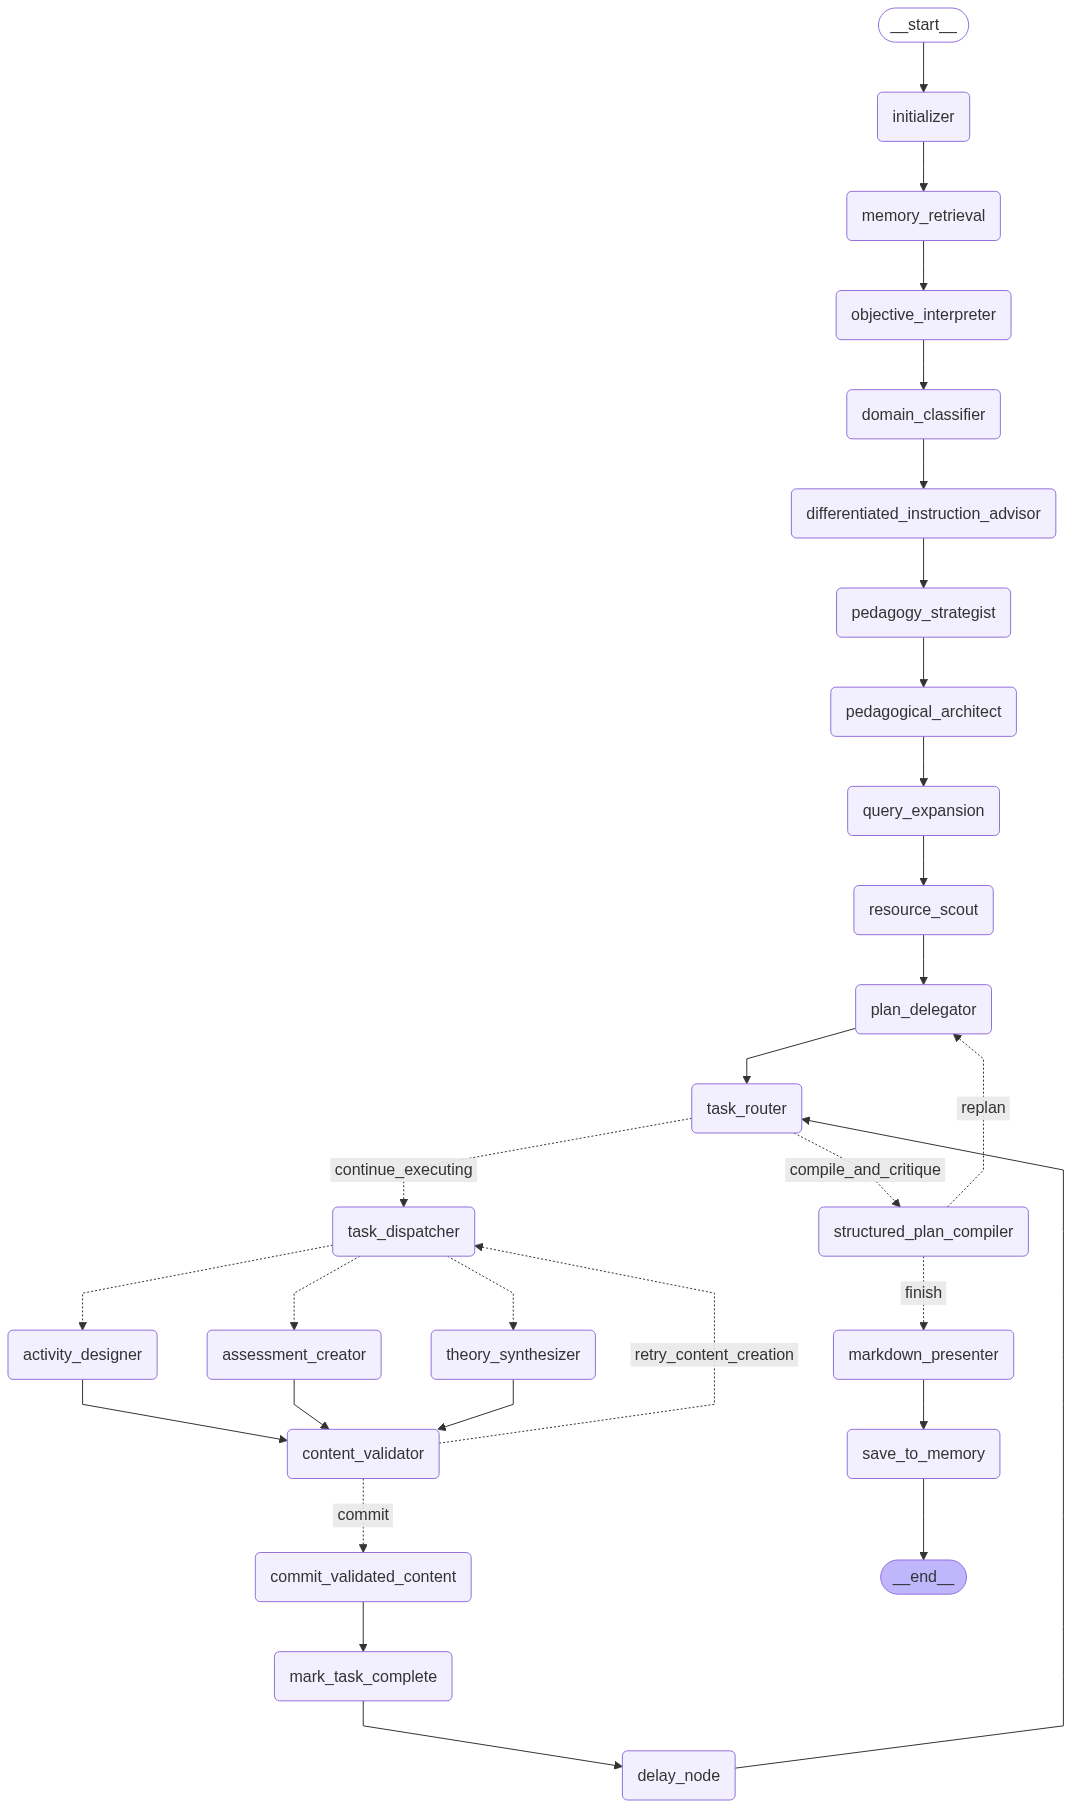

In [36]:
# ==============================================================================
# CELL 4.4: HIỂN THỊ SƠ ĐỒ GRAPH (TÙY CHỌN)
# ==============================================================================
try:
    # Lệnh này sẽ vẽ một sơ đồ của workflow, rất hữu ích để gỡ lỗi
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Lỗi vẽ biểu đồ: {e}. Đây là lỗi không nghiêm trọng, bạn vẫn có thể chạy quy trình.")

## PHẦN 5

In [37]:
# ==============================================================================
# CELL 5.1: ĐỊNH NGHĨA HÀM CHẠY QUY TRÌNH (v12.0 - HOÀN THIỆN)
# ==============================================================================
async def run_architect(user_request: str):
    if 'llm' not in globals() or llm is None:
        print_warning("LLM chưa được khởi tạo.")
        return
    if 'vector_store' not in globals() or vector_store is None:
        print_warning("Kho tri thức chưa được tải.")
        return
    if 'app' not in globals():
        print_warning("Graph 'app' chưa được biên dịch.")
        return

    initial_state = {"messages": [HumanMessage(content=user_request)]}
    console.print(f"\n[bold magenta]🚀 BẮT ĐẦU QUY TRÌNH V12.0 (HOÀN THIỆN) VỚI YÊU CẦU:[/bold magenta]\n> {user_request}")
    config = {"recursion_limit": 150} 
    
    final_markdown_plan = None
    final_structured_plan = None
    
    try:
        async for event in app.astream(initial_state, config=config):
            for node_name, node_output in event.items():
                console.print(f"\n[bold yellow]------- Hoàn thành bước: {node_name} -------[/bold yellow]")
                if node_name == "markdown_presenter":
                    final_markdown_plan = node_output.get("final_markdown_plan")
                    final_structured_plan = node_output.get("final_structured_plan")

        console.print("\n[bold magenta]🏁 KẾT THÚC QUY TRÌNH.[/bold magenta]")
        
        if final_markdown_plan:
            console.print("\n[bold green]📝 GIÁO ÁN HOÀN CHỈNH (v12.0)[/bold green]")
            console.print(Markdown(final_markdown_plan))
            
            if VERBOSE_MODE and final_structured_plan:
                print_result(final_structured_plan, "Output JSON có cấu trúc")
        else:
            print_warning("Không tạo được giáo án cuối cùng. Vui lòng kiểm tra log để gỡ lỗi.")
            
    except Exception as e:
        print_warning(f"Đã xảy ra lỗi nghiêm trọng trong quá trình chạy graph: {e}")
        import traceback
        traceback.print_exc()

print("✅ Hàm `run_architect` (v12.0) đã sẵn sàng để sử dụng.")

✅ Hàm `run_architect` (v12.0) đã sẵn sàng để sử dụng.


In [38]:
# ==============================================================================
# CELL 5.2: KÍCH HOẠT CHẠY THỬ NGHIỆM
# ==============================================================================
# Yêu cầu để kiểm tra
architect_request = "Soạn giúp tôi giáo án bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp' cho học sinh lớp 9 trong 90 phút. Đây là một lớp học khá yếu, các em thường mất tập trung và cần các hoạt động có tính tương tác cao."
VERBOSE_MODE = True 

# Chạy quy trình đã được cải cách
# Lưu ý: bạn cần một môi trường hỗ trợ `await` ở cấp độ cao nhất (như Jupyter Notebook)
await run_architect(architect_request)

🚀 BẮT ĐẦU QUY TRÌNH V12.0 (HOÀN THIỆN) VỚI YÊU CẦU:
> Soạn giúp tôi giáo án bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp' cho học sinh lớp 9 trong 90 phút. Đây là
một lớp học khá yếu, các em thường mất tập trung và cần các hoạt động có tính tương tác cao.

> `Initializer`: Đang khởi tạo trạng thái và lấy yêu cầu gốc...

------- Hoàn thành bước: initializer -------

> `Agent: Memory Retrieval` (v9.4) đang tìm kiếm trong trí nhớ...

✔️ Tìm thấy ví dụ tương đồng trong trí nhớ:

"Soạn giúp tôi giáo án bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp' cho học sinh lớp 9 trong 90 phút. Đây là một lớp học khá yếu, các em thường mất tập trung và cần các hoạt động có tính tương tác cao."

------- Hoàn thành bước: memory_retrieval -------

> `Agent: Objective Interpreter` (v7.5) đang phân tích mục tiêu...

✔️ Mục tiêu & Ràng buộc đã phân tích:

{
│   'action_verb': 'Soạn',
│   'bloom_level': 3,
│   'topic': 'Đường tròn ngoại tiếp và đường tròn nội tiếp',
│   'grade_level': 'Lớp 9',
│   'constraints': {
│   │   'duration_minutes': 90
│   }
}

------- Hoàn thành bước: objective_interpreter -------

> `Agent: Domain Classifier` (v7.5) đang xác định lĩnh vực chuyên môn...

✔️ Lĩnh vực chuyên môn được xác định:

'Toán học'

------- Hoàn thành bước: domain_classifier -------

> `Agent: Differentiated Instruction Advisor` (v9.1) đang phân tích và đề xuất chiến lược phân hóa...

✔️ Hồ sơ lớp học và Chiến lược Phân hóa:

{
│   'learning_pace': 'chậm',
│   'engagement_style': 'thụ động',
│   'special_notes': 'Lớp học có tốc độ tiếp thu chậm, dễ mất tập trung, cần các hoạt động tương tác cao để duy trì sự chú ý và hứng thú.',
│   'differentiation_strategy': {
│   │   'for_struggling_students': 'Chia nhỏ kiến thức thành các phần nhỏ, sử dụng nhiều hình ảnh trực quan và mô hình. Cung cấp phiếu bài tập có gợi ý, ví dụ minh họa chi tiết. Tổ chức các hoạt động nhóm nhỏ với vai trò rõ ràng, giáo viên thường xuyên kiểm tra, hỗ trợ trực tiếp và kịp thời. Cho phép thêm thời gian cho các bài tập khó.',
│   │   'for_advanced_students': 'Giao các bài tập nâng cao, bài toán chứng minh hoặc bài toán ứng dụng thực tế có nhiều bước. Khuyến khích các em tự tìm tòi, khám phá các tính chất mở rộng hoặc mối liên hệ giữa các khái niệm. Cho phép các em hỗ trợ, hướng dẫn các bạn trong nhóm (có sự giám sát của giáo viên). Chuẩn bị các câu hỏi mở rộng để kích thích tư duy phản biện.'
│   }
}

------- Hoàn thành bước: differentiated_instruction_advisor -------

> `Agent: Pedagogy Strategist` (v7.5) đang xây dựng chiến lược sư phạm chi tiết...

✔️ Chiến lược sư phạm chi tiết:

{
│   'name': 'Dạy học hợp tác (Cooperative Learning)',
│   'rationale': "Phương pháp Dạy học hợp tác là lựa chọn phù hợp nhất cho lớp học này vì nó trực tiếp giải quyết các đặc điểm của học sinh: tốc độ tiếp thu chậm, dễ mất tập trung và phong cách học thụ động. Bằng cách chia học sinh thành các nhóm nhỏ, mỗi em đều có vai trò và trách nhiệm, khuyến khích sự tương tác và tham gia tích cực. Học sinh có thể hỗ trợ lẫn nhau, giúp các em tiếp thu chậm dễ dàng hơn trong việc nắm bắt kiến thức, đồng thời tạo cơ hội cho học sinh khá giỏi củng cố và mở rộng hiểu biết thông qua việc hướng dẫn bạn bè. Các hoạt động nhóm đa dạng, có sự giám sát và hỗ trợ của giáo viên sẽ duy trì sự chú ý và hứng thú của học sinh trong suốt 90 phút, giúp các em 'soạn' (tức là xây dựng, tổng hợp) kiến thức về đường tròn ngoại tiếp và nội tiếp một cách chủ động và hiệu quả.",
│   'key_actions': [
│   │   'Giới thiệu bài toán/tình huống thực tế liên quan đến đường tròn ngoại tiếp và nội tiếp để tạo động lực và định hướng.',
│   │   "Chia lớp thành các nhóm nhỏ (4-5 học sinh) và phân công nhiệm vụ cụ thể cho mỗi nhóm (ví dụ: nhóm 1 tìm hiểu cách xác định tâm và bán kính đường tròn ngoại tiếp tam giác; nhóm 2 tìm hiểu cách xác định tâm và bán kính đường tròn nội tiếp tam giác; nhóm 3 'soạn' các bước vẽ hoặc giải một dạng bài tập cụ thể).",
│   │   "Các nhóm cùng nhau thảo luận, sử dụng tài liệu, dụng cụ (thước, compa) để thực hành vẽ, khám phá tính chất và 'soạn' ra các khái niệm, tính chất, cách vẽ, hoặc các bước giải bài tập liên quan đến nhiệm vụ được giao. Giáo viên quan sát, gợi ý, hỗ trợ kịp thời cho từng nhóm, đặc biệt là các nhóm học sinh chậm.",
│   │   'Đại diện các nhóm trình bày sản phẩm của mình (có thể là bản vẽ, sơ đồ tư duy, các bước giải chi tiết, hoặc bảng tổng hợp tính chất) trước lớp.',
│   │   'Cả lớp cùng giáo viên thảo luận, nhận xét, bổ sung cho các phần trình bày của các nhóm. Giáo viên tổng kết, hệ thống hóa kiến thức trọng tâm về đường tròn ngoại tiếp và nội tiếp, đồng thời sửa chữa các sai sót (nếu có).'
│   ]
}

------- Hoàn thành bước: pedagogy_strategist -------

> `Agent: Pedagogical Architect` (v9.4) đang thiết kế kịch bản buổi học...

✔️ Bản thiết kế Sư phạm đã được tạo:

[
│   'Khởi động và Đặt vấn đề: "Thức tỉnh tư duy": Giáo viên trình chiếu một hình ảnh hoặc video ngắn (khoảng 1-2 phút) về các vật thể, công trình kiến trúc, hoặc thiết kế có sử dụng hình ảnh đường tròn ngoại tiếp/nội tiếp (ví dụ: logo, bánh răng, thiết kế sân vận động, cách sắp xếp vật thể trong không gian). Sau đó, giáo viên đặt câu hỏi gợi mở: "Các em có nhận ra hình ảnh quen thuộc nào trong các ví dụ này không? Theo các em, tại sao người ta lại sử dụng những hình tròn này trong thiết kế/cấu trúc đó?" Học sinh có 2 phút để suy nghĩ cá nhân, sau đó chia sẻ nhanh ý kiến với bạn bên cạnh. Giáo viên mời 2-3 học sinh chia sẻ trước lớp, sau đó dẫn dắt khéo léo vào chủ đề bài học: Đường tròn ngoại tiếp và đường tròn nội tiếp tam giác, nêu rõ mục tiêu cần đạt được.',
│   'Khám phá và Xây dựng kiến thức: "Kiến tạo tri thức": Giáo viên chia lớp thành các nhóm nhỏ (4-5 học sinh). Mỗi nhóm được phát tài liệu học tập (có thể là phiếu học tập, sách giáo khoa, hoặc tài liệu tham khảo ngắn gọn) và dụng cụ học tập (thước, compa, giấy vẽ). Giáo viên phân công nhiệm vụ cụ thể cho từng nhóm: Nhóm 1 và 2 tập trung khám phá về đường tròn ngoại tiếp tam giác (định nghĩa, tính chất, cách xác định tâm và bán kính, đặc biệt với tam giác vuông/đều). Nhóm 3 và 4 tập trung khám phá về đường tròn nội tiếp tam giác (định nghĩa, tính chất, cách xác định tâm và bán kính, đặc biệt với tam giác vuông/đều). Các nhóm cùng nhau đọc tài liệu, thảo luận, thực hành vẽ hình và \'soạn\' (ghi chép, sơ đồ hóa) các kiến thức trọng tâm theo nhiệm vụ được giao. Giáo viên đi quanh các nhóm, quan sát, lắng nghe, và hỗ trợ kịp thời bằng cách đặt câu hỏi gợi mở, hướng dẫn các nhóm gặp khó khăn.',
│   'Trình bày và Hệ thống hóa: "Chia sẻ và Khẳng định": Đại diện các nhóm lần lượt trình bày sản phẩm của mình (có thể là bản vẽ minh họa, sơ đồ tư duy, bảng tổng hợp tính chất, hoặc các bước xác định tâm/bán kính) trước lớp. Mỗi nhóm có khoảng 3-4 phút để trình bày. Các nhóm khác lắng nghe, đặt câu hỏi và bổ sung ý kiến. Sau mỗi phần trình bày, giáo viên tổng hợp các ý kiến, chuẩn hóa kiến thức, nhấn mạnh các điểm quan trọng, đặc biệt là các tính chất đặc biệt của đường tròn ngoại tiếp/nội tiếp trong tam giác vuông, tam giác đều. Giáo viên giải đáp các thắc mắc của học sinh và hệ thống hóa toàn bộ kiến thức cốt lõi của bài học lên bảng hoặc trình chiếu.',
│   'Vận dụng và Củng cố: "Thử thách và Nâng tầm": Giáo viên đưa ra một chuỗi các bài tập vận dụng từ cơ bản đến nâng cao, có phân hóa rõ ràng. Ví dụ: Bài 1 (cơ bản): Xác định tâm và bán kính đường tròn ngoại tiếp/nội tiếp một tam giác cụ thể (có hình vẽ). Bài 2 (trung bình): Tính bán kính đường tròn ngoại tiếp/nội tiếp khi biết các yếu tố của tam giác. Bài 3 (nâng cao/ứng dụng): Một bài toán thực tế liên quan đến đường tròn ngoại tiếp/nội tiếp (ví dụ: thiết kế một chi tiết máy, xác định vị trí đặt đài phun nước trong một công viên hình tam giác). Học sinh làm việc cá nhân hoặc theo cặp. Giáo viên đi lại quan sát, hỗ trợ, và khuyến khích các em trình bày cách giải. Sau đó, giáo viên chọn một số bài tập tiêu biểu để chữa bài chung, mời học sinh lên bảng trình bày và giải thích. Cuối cùng, giáo viên tổng kết lại các kiến thức trọng tâm và giao bài tập về nhà để học sinh tiếp tục củng cố.'
]

------- Hoàn thành bước: pedagogical_architect -------

> `Agent: Query Expansion` (v7.5) đang phân tích yêu cầu...

✔️ Các truy vấn tìm kiếm đã được mở rộng:

[
│   'Đường tròn ngoại tiếp là gì',
│   'Đường tròn nội tiếp là gì',
│   'Công thức tính bán kính đường tròn ngoại tiếp tam giác',
│   'Công thức tính bán kính đường tròn nội tiếp tam giác',
│   'Tính chất đường tròn ngoại tiếp và nội tiếp',
│   'Bài tập đường tròn ngoại tiếp tam giác',
│   'Bài tập đường tròn nội tiếp tam giác',
│   'Chuyên đề đường tròn ngoại tiếp nội tiếp',
│   'Đường tròn ngoại tiếp tứ giác',
│   'Đường tròn nội tiếp tứ giác',
│   'Phương pháp giải bài tập đường tròn ngoại tiếp',
│   'Lý thuyết đường tròn ngoại tiếp và nội tiếp lớp 9',
│   'Ứng dụng đường tròn ngoại tiếp trong hình học',
│   'Quan hệ giữa đường tròn ngoại tiếp và nội tiếp tam giác',
│   'Đường tròn ngoại tiếp tam giác vuông'
]

------- Hoàn thành bước: query_expansion -------

> `Agent: Resource Scout` (v8.1 - Sửa lỗi) đang tìm kiếm và sàng lọc...

> Tìm thấy 75 tài liệu, sàng lọc còn 8 đoạn văn bản độc nhất.

✔️ Tài liệu RAG cuối cùng:

{
│   'source': 'Sách giáo khoa (từ RAG - đã sàng lọc)',
│   'summary': 'Chào em,\n\nVới vai trò là một giáo viên giàu kinh nghiệm, thầy/cô đã tổng hợp các thông tin từ các đoạn văn bản em cung cấp để xây dựng bản tóm tắt này. Dựa trên **chỉ** những nội dung có sẵn, kiến thức cốt lõi liên quan đến đường tròn được thể hiện như sau.\n\nCần lưu ý rằng các khái niệm chuyên biệt về "đường tròn ngoại tiếp" và "đường tròn nội tiếp" của một đa giác (ví dụ như tam giác) không được trình bày trực tiếp trong các đoạn văn bản này. Thay vào đó, thông tin chủ yếu tập trung vào các tính chất và vị trí tương đối của hai đường tròn nói chung.\n\n---\n\n**TÓM TẮT KIẾN THỨC CỐT LÕI VỀ CHỦ ĐỀ "ĐƯỜNG TRÒN NGOẠI TIẾP VÀ ĐƯỜNG TRÒN NỘI TIẾP" (Dựa trên văn bản cung cấp)**\n\n**1. Khái niệm chung về Đường tròn:**\n*   Đường tròn là một hình học cơ bản, có thể được nhận biết trong các vật thể thực tế (ví dụ: sản phẩm mây tre đan).\n*   Một đường tròn được xác định bởi tâm và bán kính của nó (ví dụ: đường tròn (O; 3 cm)).\n\n**2. Vị trí tương đối của hai đường tròn:**\nCác đoạn văn bản đề cập đến các trường hợp vị trí tương đối giữa hai đường tròn:\n*   **Cắt nhau:** Hai đường tròn có hai điểm chung phân biệt. (Ví dụ 5.24, Ví dụ 1)\n*   **Không giao nhau:** Hai đường tròn không có điểm chung nào. (Ví dụ 5.24)\n*   **Tiếp xúc ngoài:** Hai đường tròn có một điểm chung duy nhất và nằm về hai phía của tiếp tuyến chung tại điểm đó. Điều này xảy ra khi khoảng cách giữa hai tâm bằng tổng hai bán kính (OO\' = R + r). (Ví dụ 5.26a, 5.27)\n*   **Tiếp xúc trong:** Hai đường tròn có một điểm chung duy nhất và một đường tròn nằm bên trong đường tròn kia (trừ điểm tiếp xúc). Điều này xảy ra khi khoảng cách giữa hai tâm bằng hiệu hai bán kính (OO\' = |R - r|). (Ví dụ 5.26b, 5.26c)\n\n**3. Các tính chất và khái niệm liên quan đến Đường tròn:**\n*   **Đối xứng:** Các cung tròn có thể có tính đối xứng, cho phép chúng chắp nối trơn tru.\n*   **Dây cung:** Là đoạn thẳng nối hai điểm trên đường tròn. (Được suy luận từ mục lục "Cung và dây của một đường tròn").\n*   **Tiếp tuyến:** Một đường thẳng có thể tiếp xúc với một đường tròn tại một điểm duy nhất. (Ví dụ 1b: "đường thẳng MN tiếp xúc với đường tròn đường kính AB").\n*   **Đường tròn đường kính:** Một đường tròn có thể được xác định bởi một đường kính của nó. (Ví dụ 1b)\n*   **Cung tròn:** Một phần của đường tròn. (Được suy luận từ mục lục "Cung và dây của một đường tròn").'
}

------- Hoàn thành bước: resource_scout -------

> `Agent: Plan Delegator` (v12.0 - Nhà hoạch định Thông thái) đang triển khai...

✔️ Đã tạo 5 nhiệm vụ chi tiết:

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khởi động và Đặt vấn đề',
│   │   'task_description': 'Giáo viên trình chiếu hình ảnh/video, đặt câu hỏi gợi mở về ứng dụng đường tròn ngoại tiếp/nội tiếp. Học sinh suy nghĩ cá nhân, chia sẻ nhóm và trình bày trước lớp. Giáo viên dẫn dắt vào bài học và nêu mục tiêu.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Khám phá và Xây dựng kiến thức mới',
│   │   'task_description': 'Học sinh chia nhóm, nhận tài liệu và dụng cụ. Các nhóm khám phá về đường tròn ngoại tiếp hoặc nội tiếp tam giác (định nghĩa, tính chất, cách xác định tâm/bán kính, trường hợp đặc biệt). Giáo viên quan sát, hỗ trợ và gợi mở.',
│   │   'estimated_duration': 35,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Trình bày và Hệ thống hóa kiến thức',
│   │   'task_description': 'Đại diện các nhóm trình bày sản phẩm khám phá của mình. Các nhóm khác lắng nghe, đặt câu hỏi và bổ sung. Giáo viên tổng hợp, chuẩn hóa kiến thức, nhấn mạnh các điểm trọng tâm và giải đáp thắc mắc.',
│   │   'estimated_duration': 25,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Vận dụng và Củng cố kiến thức',
│   │   'task_description': 'Học sinh thực hiện chuỗi bài tập vận dụng từ cơ bản đến nâng cao (cá nhân hoặc theo cặp). Giáo viên quan sát, hỗ trợ và mời học sinh lên bảng chữa bài.',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Tổng kết bài học và Giao bài tập về nhà',
│   │   'task_description': 'Giáo viên tổng kết lại các kiến thức trọng tâm của bài học và giao bài tập về nhà để học sinh tiếp tục củng cố và mở rộng.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khởi động và Đặt vấn đề' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `assessment_creator`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Assessment Creator` (v12.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Assessment Creator tạo ra:

{
│   'activity_name': 'Khởi động và Đặt vấn đề',
│   'duration_minutes': 10,
│   'teacher_actions': [
│   │   "Giới thiệu hoạt động 'Khởi động và Đặt vấn đề' (1 phút).",
│   │   'Trình bày câu hỏi cốt lõi và yêu cầu học sinh suy nghĩ cá nhân trong 3 phút.',
│   │   'Mời 2-3 học sinh xung phong chia sẻ ý kiến của mình (4 phút).',
│   │   'Tổng kết các ý kiến, nhấn mạnh tầm quan trọng của việc ra quyết định có cơ sở và dẫn dắt vào nội dung bài học mới (2 phút).'
│   ],
│   'core_component': 'Hãy tưởng tượng bạn đang ở trong một tình huống khó khăn và cần đưa ra một quyết định quan trọng. Bạn sẽ làm gì để đảm bảo quyết định của mình là tốt nhất có thể?',
│   'extension_component': 'Nếu bạn chỉ có 1 phút để đưa ra quyết định đó, bạn sẽ ưu tiên điều gì và tại sao?',
│   'answer': 'Để đưa ra quyết định tốt nhất, cần thu thập thông tin đầy đủ, phân tích các lựa chọn, cân nhắc ưu nhược điểm, dự đoán hậu quả và tham khảo ý kiến nếu cần.',
│   'solution_guide': None,
│   'differentiation': {
│   │   'for_struggling_students': "Gợi ý các câu hỏi dẫn dắt để học sinh dễ dàng hình dung và đưa ra ý tưởng: 'Bạn sẽ tìm thông tin ở đâu?', 'Ai có thể giúp bạn trong tình huống này?', 'Bạn sẽ nghĩ đến những hậu quả nào?'. Khuyến khích các em nói ra ý tưởng dù chưa hoàn chỉnh.",
│   │   'for_advanced_students': 'Yêu cầu học sinh đưa ra một ví dụ cụ thể về tình huống khó khăn mà họ hoặc người thân đã gặp phải, và cách họ đã áp dụng (hoặc sẽ áp dụng) các bước để đưa ra quyết định. Thử thách các em phản biện lại một quan điểm khác về cách ra quyết định.'
│   },
│   'content_type': 'Tự luận'
}

------- Hoàn thành bước: assessment_creator -------

> `Agent: Guardian Critic` (v12.0) đang bảo vệ kế hoạch...

> ✔️ GUARDIAN: Nội dung tuân thủ kế hoạch!

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

------- Hoàn thành bước: delay_node -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khám phá và Xây dựng kiến thức mới' (ID: 1)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá và Xây dựng kiến thức mới',
│   'duration_minutes': 35,
│   'teacher_actions': [
│   │   'Giới thiệu mục tiêu hoạt động và phân công nhiệm vụ rõ ràng.',
│   │   'Chia nhóm học sinh, phân phát tài liệu và hướng dẫn về thời gian cho từng phần.',
│   │   'Quan sát, lắng nghe các nhóm thảo luận, đi vòng quanh để hỗ trợ, gợi ý và đặt câu hỏi mở nhằm thúc đẩy tư duy.',
│   │   'Tổ chức phần trình bày ngắn gọn của các nhóm (nếu thời gian cho phép, mỗi nhóm 1 phút).',
│   │   'Tổng kết các ý chính đã được khám phá, giải đáp nhanh các thắc mắc chung và chuyển tiếp sang hoạt động tiếp theo.'
│   ],
│   'core_component': 'Học sinh làm việc theo nhóm (4-5 người) để nghiên cứu tài liệu/video/bài đọc được cung cấp về chủ đề mới. Các nhóm thảo luận để: 1. Xác định 3-5 khái niệm/ý chính quan trọng nhất. 2. Đặt 1-2 câu hỏi về những điểm chưa rõ hoặc muốn tìm hiểu sâu hơn. 3. Chuẩn bị trình bày ngắn gọn (1-2 phút/nhóm) về những gì nhóm đã khám phá và câu hỏi của nhóm.',
│   'extension_component': 'Học sinh tiếp tục tìm kiếm các ví dụ thực tế hoặc ứng dụng của kiến thức vừa học trong đời sống hoặc các lĩnh vực khác. Chuẩn bị một câu hỏi thách thức hoặc một vấn đề mở rộng liên quan đến chủ đề để chia sẻ với cả lớp.',
│   'solution_guide': "Các câu hỏi gợi mở để tổng kết và củng cố kiến thức: 'Ba điều quan trọng nhất bạn học được hôm nay là gì?', 'Bạn sẽ áp dụng kiến thức này vào đâu trong thực tế?', 'Có điều gì bạn muốn tìm hiểu sâu hơn về chủ đề này không?', 'Làm thế nào để giải thích khái niệm [Tên khái niệm] cho một người bạn?'",
│   'differentiation': {
│   │   'for_struggling_students': "Cung cấp tài liệu đã được tóm tắt, có từ khóa nổi bật hoặc hình ảnh minh họa. Gợi ý các câu hỏi dẫn dắt cụ thể hơn (ví dụ: 'Khái niệm X là gì?', 'Nó có đặc điểm gì?'). Khuyến khích các em đặt câu hỏi đơn giản nhất để bắt đầu và ghép nhóm với học sinh khá giỏi để nhận được sự hỗ trợ.",
│   │   'for_advanced_students': 'Yêu cầu các em tìm kiếm thêm thông tin từ nguồn bên ngoài (sách giáo khoa nâng cao, internet) để bổ sung cho tài liệu được cung cấp. Thách thức các em liên hệ kiến thức mới với các chủ đề đã học hoặc đưa ra các ứng dụng tiềm năng trong tương lai. Yêu cầu chuẩn bị một câu hỏi phản biện sâu sắc cho các nhóm khác.'
│   },
│   'content_type': 'Thảo luận nhóm và Thực hành cá nhân'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động này được thiết kế khá chi tiết và có nhiều yếu tố tích cực, tuy nhiên, với thời 
lượng 35 phút, nội dung này là quá tải và khó có thể thực hiện hiệu quả. Cụ thể:
- Phần "Khám phá và Xây dựng kiến thức mới" yêu cầu học sinh nghiên cứu tài liệu/video/bài đọc về chủ đề mới, xác 
định 3-5 khái niệm, đặt câu hỏi và chuẩn bị trình bày. Đây là một khối lượng công việc lớn, đặc biệt khi là kiến 
thức mới, sẽ cần nhiều thời gian hơn 15-20 phút cho hoạt động nhóm.
- Việc tổ chức trình bày cho các nhóm (dù chỉ 1 phút/nhóm) cũng sẽ tiêu tốn đáng kể thời gian (ví dụ 5 nhóm đã là 5
phút).
- Phần "extension_component" (mở rộng) yêu cầu học sinh tiếp tục tìm kiếm ví dụ thực tế hoặc ứng dụng và chuẩn bị 
câu hỏi thách thức, điều này gần như không thể thực hiện được trong thời gian còn lại sau khi hoàn thành phần cốt 
lõi và trình bày.

Hoạt động này có thể phù hợp hơn với một tiết học dài hơn (ví dụ 45-60 phút) hoặc cần được tinh giản đáng kể để phù
hợp với 35 phút. Hãy thiết kế lại một phiên bản đơn giản hơn để khớp với thời gian 35 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá và Xây dựng kiến thức mới',
│   'duration_minutes': 35,
│   'teacher_actions': [
│   │   'Giới thiệu chủ đề và mục tiêu hoạt động.',
│   │   'Phân chia nhóm và phát tài liệu/hướng dẫn truy cập tài liệu.',
│   │   'Giải thích rõ ràng nhiệm vụ: xác định ý chính và đặt câu hỏi.',
│   │   'Di chuyển giữa các nhóm, lắng nghe, gợi ý, hỗ trợ khi cần thiết (ví dụ: gợi ý câu hỏi, làm rõ khái niệm).',
│   │   'Theo dõi thời gian và thông báo khi còn 5 phút để các nhóm hoàn tất sản phẩm.',
│   │   'Yêu cầu các nhóm dán/đặt sản phẩm của mình lên bảng/khu vực quy định.',
│   │   'Tổ chức phần chia sẻ nhanh: Mời đại diện 1-2 nhóm chia sẻ ý chính và câu hỏi của nhóm mình (mỗi nhóm không quá 1 phút).',
│   │   'Tổng hợp các ý chính và câu hỏi chung của cả lớp, giải đáp nhanh các thắc mắc hoặc định hướng cho buổi học tiếp theo.'
│   ],
│   'core_component': 'Học sinh làm việc theo nhóm (3-4 người). Giáo viên cung cấp một đoạn văn bản ngắn (hoặc một đoạn video/audio clip) về chủ đề mới. Nhiệm vụ của nhóm là: 1. Đọc/xem/nghe tài liệu và xác định 1-2 ý chính/khái niệm cốt lõi được đề cập. 2. Thảo luận trong nhóm để hiểu rõ các ý chính này. 3. Mỗi nhóm chuẩn bị một bản tóm tắt ngắn gọn (2-3 câu) về ý chính và đặt 1 câu hỏi liên quan đến nội dung mà nhóm muốn tìm hiểu thêm hoặc còn thắc mắc. Sản phẩm có thể là ghi chú trên giấy A4 hoặc bảng nhóm nhỏ.',
│   'extension_component': 'Nếu còn thời gian hoặc nhóm hoàn thành sớm, các nhóm có thể thử trả lời một câu hỏi của nhóm khác (nếu các câu hỏi được hiển thị) hoặc tìm một ví dụ thực tế đơn giản minh họa cho một trong các khái niệm vừa học.',
│   'solution_guide': "Các ý chính/khái niệm cốt lõi cần được học sinh xác định (liệt kê cụ thể các ý này). Gợi ý các dạng câu hỏi mà học sinh có thể đặt (ví dụ: 'Tại sao...?', 'Làm thế nào để...?', 'Ý nghĩa của... là gì?').",
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp tài liệu đã được lược giản, gạch chân các từ khóa quan trọng hoặc cung cấp các câu hỏi gợi ý cụ thể để định hướng việc tìm ý chính. Giáo viên dành nhiều thời gian hơn để hỗ trợ trực tiếp nhóm này, có thể gợi ý cấu trúc câu hỏi.',
│   │   'for_advanced_students': 'Khuyến khích học sinh tìm kiếm mối liên hệ giữa kiến thức mới với các kiến thức đã học hoặc các vấn đề thực tế. Yêu cầu các em đặt câu hỏi mang tính phản biện hoặc mở rộng, dự đoán các ứng dụng tiềm năng của khái niệm mới.'
│   },
│   'content_type': 'Thảo luận nhóm và Tổng hợp kiến thức'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Kế hoạch hoạt động này được xây dựng khá chi tiết và có cấu trúc tốt, các bước rõ ràng, có 
tính phân hóa cho các đối tượng học sinh khác nhau. Tuy nhiên, thời lượng 35 phút được phân bổ cho hoạt động "Khám 
phá và Xây dựng kiến thức mới" là quá eo hẹp và không thực sự khả thi để đảm bảo chất lượng học tập. Việc học sinh 
phải đọc/xem tài liệu, thảo luận nhóm sâu, xác định ý chính, tóm tắt, đặt câu hỏi, sau đó còn có thời gian cho 1-2 
nhóm chia sẻ và giáo viên tổng hợp, giải đáp thắc mắc, định hướng, sẽ rất khó để hoàn thành một cách hiệu quả trong
35 phút. Các em sẽ bị thúc ép về thời gian, khó có thể tư duy sâu và tiếp thu kiến thức mới một cách trọn vẹn. Hãy 
thiết kế lại một phiên bản đơn giản hơn để khớp với thời gian 35 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá và Xây dựng kiến thức trọng tâm',
│   'duration_minutes': 35,
│   'teacher_actions': [
│   │   'Giới thiệu mục tiêu và hướng dẫn hoạt động rõ ràng, ngắn gọn (2 phút).',
│   │   'Phân phát tài liệu hoặc hướng dẫn truy cập tài liệu nhanh chóng (1 phút).',
│   │   'Theo dõi, hỗ trợ các nhóm, giải đáp thắc mắc nhanh và định hướng thảo luận (10 phút).',
│   │   'Quản lý thời gian chặt chẽ, nhắc nhở các nhóm chuyển giai đoạn (liên tục).',
│   │   'Mời 1-2 nhóm đại diện chia sẻ nhanh kết quả (5 phút).',
│   │   'Tổng hợp, chốt kiến thức trọng tâm, giải đáp các câu hỏi còn lại và định hướng cho hoạt động tiếp theo (12 phút).'
│   ],
│   'core_component': 'Học sinh làm việc theo nhóm (3-4 người). Mỗi nhóm được cung cấp một đoạn văn bản ngắn gọn hoặc một video clip đã được chọn lọc kỹ càng (tối đa 3-5 phút) liên quan đến chủ đề. Nhiệm vụ của nhóm là:\n1. Đọc/xem nhanh tài liệu để nắm bắt thông tin chính (5 phút).\n2. Thảo luận để xác định 2-3 ý chính hoặc trả lời các câu hỏi gợi mở cụ thể do giáo viên cung cấp (10 phút).\n3. Chuẩn bị 1-2 câu tóm tắt hoặc câu trả lời đại diện của nhóm để chia sẻ nhanh (5 phút).\nGiáo viên sẽ mời 1-2 nhóm chia sẻ nhanh, sau đó tổng hợp và chốt kiến thức trọng tâm.',
│   'extension_component': 'Học sinh hoàn thành nhanh có thể: Tìm thêm ví dụ thực tế liên quan đến kiến thức vừa học hoặc đặt 1-2 câu hỏi sâu hơn về chủ đề để giáo viên hoặc các bạn cùng giải đáp trong phần tổng kết.',
│   'solution_guide': 'Các ý chính cần đạt được từ hoạt động này là [Liệt kê 2-3 ý chính dự kiến của bài học]. Giáo viên cần chuẩn bị sẵn các câu hỏi gợi mở để dẫn dắt học sinh đến các ý này một cách hiệu quả trong thời gian giới hạn.',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp tài liệu đã được tóm tắt/gạch chân ý chính hoặc phiên bản đơn giản hóa. Ghép cặp với học sinh khá hơn. Giáo viên dành thời gian hỗ trợ trực tiếp, đặt câu hỏi gợi mở đơn giản hơn và khuyến khích các em nói ra suy nghĩ của mình.',
│   │   'for_advanced_students': 'Khuyến khích tìm kiếm thông tin bổ sung nhanh (nếu có thiết bị và thời gian). Yêu cầu phân tích sâu hơn về mối liên hệ giữa các ý chính hoặc dự đoán ứng dụng của kiến thức trong thực tế. Chuẩn bị sẵn sàng để trình bày hoặc hỗ trợ các nhóm khác khi cần.'
│   },
│   'content_type': 'Thảo luận nhóm và Xây dựng kiến thức'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Kế hoạch hoạt động này không khả thi trong 35 phút đã cho. Tổng thời gian ước tính cho các 
bước chi tiết (3 phút giới thiệu/phân phát + 20 phút làm việc nhóm + 5 phút chia sẻ + 12 phút tổng kết) là 40 phút,
vượt quá 5 phút so với thời lượng cho phép. Để đảm bảo tuân thủ kế hoạch gốc, hãy thiết kế lại một phiên bản đơn 
giản hơn để khớp với thời gian 35 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v12.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Theory Synthesizer tạo ra:

{
│   'activity_name': 'Khám phá và Xây dựng kiến thức mới',
│   'duration_minutes': 35,
│   'teacher_actions': [
│   │   'Giới thiệu mục tiêu hoạt động và phân phát tài liệu/nhiệm vụ cho các nhóm (3 phút).',
│   │   'Quan sát, lắng nghe, đi lại giữa các nhóm để hỗ trợ, giải đáp thắc mắc, và gợi ý khi cần thiết, đảm bảo các nhóm đi đúng hướng (18 phút).',
│   │   'Điều phối phần chia sẻ của các nhóm, khuyến khích các nhóm khác đặt câu hỏi hoặc bổ sung (4 phút).',
│   │   'Tổng kết các ý chính, chốt kiến thức mới, làm rõ những điểm còn mơ hồ và mở rộng vấn đề nếu có (10 phút).'
│   ],
│   'core_component': 'Học sinh làm việc theo nhóm (4-5 em) để đọc, phân tích tài liệu/tình huống được giao (ví dụ: một đoạn văn bản, một bài toán, một trường hợp thực tế) nhằm khám phá và rút ra các kiến thức, khái niệm mới. Mỗi nhóm cần tóm tắt những phát hiện chính và chuẩn bị một đại diện để chia sẻ ngắn gọn (khoảng 1 phút/nhóm) trước lớp. Trọng tâm là việc tự lực khám phá và tổng hợp thông tin ban đầu.',
│   'extension_component': 'Nếu các nhóm hoàn thành sớm phần cốt lõi, khuyến khích các em chuẩn bị thêm một ví dụ thực tế minh họa cho kiến thức vừa khám phá, hoặc tự đặt câu hỏi cho các nhóm khác về nội dung đã học.',
│   'solution_guide': "Các câu hỏi gợi mở: 'Các em đã tìm thấy những điểm mới nào trong tài liệu?', 'Khái niệm/vấn đề chính mà tài liệu đề cập là gì?', 'Các em có thể tóm tắt nội dung này trong một câu không?'. Sau khi các nhóm chia sẻ, giáo viên cần chốt lại các khái niệm/kiến thức trọng tâm, đảm bảo tất cả học sinh đều nắm được.",
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp tài liệu đơn giản hóa, có sẵn các câu hỏi gợi ý cụ thể hoặc từ khóa quan trọng. Giáo viên có thể dành thêm thời gian hỗ trợ trực tiếp nhóm này, hoặc ghép nhóm với học sinh khá để nhận được sự giúp đỡ từ bạn bè.',
│   │   'for_advanced_students': 'Cung cấp tài liệu có độ phức tạp cao hơn, hoặc yêu cầu các em không chỉ khám phá mà còn đề xuất giải pháp/ứng dụng kiến thức vào một tình huống mới. Khuyến khích các em tự đặt câu hỏi phản biện hoặc tìm kiếm thêm thông tin mở rộng.'
│   },
│   'content_type': 'Thảo luận nhóm và Tổng kết'
}

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Guardian Critic` (v12.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Chào bạn, với vai trò là Người Bảo vệ Kế hoạch, tôi đã xem xét kỹ lưỡng nội dung hoạt động 
bạn đề xuất. Về mặt cấu trúc và các thành phần hoạt động, kế hoạch này khá chi tiết và hợp lý cho một buổi khám phá
kiến thức mới. Các bước giáo viên thực hiện cũng được phân bổ rõ ràng. Tuy nhiên, khi xét đến tính khả thi trong 
khung thời gian 35 phút đã cho, tôi nhận thấy có một điểm chưa hợp lý. Tổng thời gian các hoạt động của giáo viên 
cộng lại là 35 phút (3 + 18 + 4 + 10), khớp với kế hoạch. Nhưng phần "Điều phối phần chia sẻ của các nhóm" chỉ có 4
phút, trong khi mỗi nhóm cần khoảng 1 phút để chia sẻ. Điều này có nghĩa là nếu lớp có từ 5 nhóm trở lên, thời gian
sẽ không đủ. Ngay cả khi chỉ có 4 nhóm, 1 phút/nhóm là rất gấp gáp và gần như không còn thời gian để "khuyến khích 
các nhóm khác đặt câu hỏi hoặc bổ sung" như mục tiêu đã nêu. Điều này sẽ làm giảm chất lượng của phần tổng kết và 
tương tác giữa các nhóm. Do đó, hoạt động này có vẻ hơi tham vọng so với thời lượng cho phép để đảm bảo hiệu quả 
tối đa. Hãy thiết kế lại một phiên bản đơn giản hơn để khớp với thời gian 35 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá và Xây dựng kiến thức mới',
│   'duration_minutes': 35,
│   'teacher_actions': [
│   │   'Giới thiệu chủ đề, mục tiêu bài học và hướng dẫn rõ ràng về nhiệm vụ khám phá kiến thức (3 phút).',
│   │   'Phân chia nhóm (nếu cần) và phát tài liệu/phiếu học tập cho các nhóm.',
│   │   'Quan sát, lắng nghe các nhóm làm việc, đi vòng quanh lớp để hỗ trợ, giải đáp thắc mắc và gợi mở tư duy khi cần (18 phút).',
│   │   'Khuyến khích học sinh tự tìm tòi, thảo luận và hợp tác. Ghi nhận nhanh các điểm chung/khác biệt trong quá trình làm việc của các nhóm để chuẩn bị cho phần tổng kết.',
│   │   'Mời 2-3 nhóm đại diện chia sẻ ngắn gọn (khoảng 2-3 phút/nhóm) về những phát hiện, kết luận quan trọng nhất của nhóm mình (10 phút).',
│   │   'Đặt câu hỏi gợi mở để các nhóm khác bổ sung hoặc phản biện (nếu có thời gian).',
│   │   'Tổng hợp các ý kiến, chốt lại kiến thức cốt lõi, làm rõ các khái niệm quan trọng và chỉnh sửa những hiểu lầm (nếu có).',
│   │   'Củng cố lại kiến thức trọng tâm của bài học và giao nhiệm vụ về nhà hoặc gợi ý các hoạt động mở rộng để học sinh tiếp tục tìm hiểu (4 phút).',
│   │   'Đánh giá nhanh mức độ hiểu bài của học sinh (ví dụ: 1 câu hỏi nhanh, giơ tay biểu quyết).'
│   ],
│   'core_component': 'Học sinh làm việc nhóm để khám phá tài liệu, dữ liệu hoặc tình huống được cung cấp, từ đó rút ra các kiến thức mới hoặc xây dựng giải pháp cho vấn đề. Các nhóm cần ghi lại những phát hiện, câu hỏi và kết luận của mình trên phiếu học tập hoặc bảng nhóm.',
│   'extension_component': 'Đối với các nhóm hoàn thành sớm hoặc học sinh có năng lực tốt, khuyến khích các em tìm kiếm thêm thông tin liên quan, đặt ra các câu hỏi sâu hơn, hoặc đề xuất các ứng dụng thực tế của kiến thức vừa học.',
│   'solution_guide': "Các câu hỏi gợi mở cho giáo viên khi điều phối: 'Các em đã tìm thấy điều gì thú vị nhất?', 'Điểm mấu chốt của vấn đề này là gì?', 'Các em có thể áp dụng kiến thức này vào đâu trong thực tế?', 'Có điểm nào các nhóm còn băn khoăn không?'. Chuẩn bị sẵn các ý chính/khái niệm cốt lõi cần được học sinh khám phá để đối chiếu và tổng kết. Dự kiến các câu trả lời/phát hiện có thể có của học sinh để dễ dàng điều hướng thảo luận.",
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp tài liệu có cấu trúc rõ ràng hơn, có sẵn các câu hỏi gợi ý hoặc khung sườn để điền thông tin. Ưu tiên ghép nhóm với các bạn có năng lực khá để nhận được sự hỗ trợ trực tiếp. Giáo viên dành thời gian ghé thăm nhóm thường xuyên hơn, đặt các câu hỏi dẫn dắt cụ thể để giúp các em bắt đầu và duy trì hoạt động. Cho phép các em chỉ tập trung vào những kiến thức cơ bản nhất.',
│   │   'for_advanced_students': "Cung cấp các tài liệu phức tạp hơn, yêu cầu phân tích sâu hơn hoặc liên hệ với các kiến thức đã học/thực tế. Khuyến khích các em tự đặt câu hỏi nghiên cứu, đề xuất các giải pháp sáng tạo hoặc mở rộng vấn đề. Giao nhiệm vụ 'chuyên gia' trong nhóm, hỗ trợ các bạn khác và trình bày phần mở rộng nếu có thời gian. Thử thách các em tìm ra nhiều cách giải quyết khác nhau cho cùng một vấn đề hoặc dự đoán các tình huống tiếp theo."
│   },
│   'content_type': 'Thảo luận nhóm và Tổng kết'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Kế hoạch hoạt động này có vẻ hợp lý về mặt nội dung và phương pháp, tuy nhiên, thời lượng 35
phút được phân bổ cho các hoạt động cụ thể đã tính toán vừa đủ, nhưng lại chưa tính đến thời gian cho một số hoạt 
động cần thiết khác như: phân chia nhóm và phát tài liệu, cũng như thời gian để giáo viên tổng hợp, chốt kiến thức 
cốt lõi một cách sâu sắc sau phần chia sẻ của học sinh. Đặc biệt, việc tổng hợp ý kiến, chốt kiến thức, làm rõ khái
niệm và chỉnh sửa hiểu lầm trong 4 phút cuối cùng cùng với củng cố và giao nhiệm vụ về nhà là quá gấp gáp, khó đảm 
bảo hiệu quả. Hoạt động này sẽ khó có thể hoàn thành một cách trọn vẹn và chất lượng trong 35 phút. Hãy thiết kế 
lại một phiên bản đơn giản hơn để khớp với thời gian 35 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v12.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Theory Synthesizer tạo ra:

{
│   'activity_name': 'Khám phá và Xây dựng kiến thức mới',
│   'duration_minutes': 35,
│   'teacher_actions': [
│   │   'Giới thiệu mục tiêu hoạt động và hướng dẫn cách thức làm việc nhóm (2 phút).',
│   │   'Phân chia nhóm nhanh chóng và phát tài liệu cho từng nhóm (3 phút).',
│   │   'Quan sát, lắng nghe, gợi ý và hỗ trợ các nhóm trong quá trình khám phá, đảm bảo tất cả học sinh đều tham gia (20 phút).',
│   │   'Mời 2-3 nhóm đại diện trình bày nhanh kết quả khám phá của nhóm mình (4 phút).',
│   │   'Tổng hợp, chốt kiến thức cốt lõi, làm rõ các khái niệm, chỉnh sửa hiểu lầm và nhấn mạnh các điểm quan trọng (4 phút).',
│   │   'Củng cố kiến thức bằng một câu hỏi nhanh hoặc ví dụ ứng dụng, và giao nhiệm vụ về nhà (2 phút).'
│   ],
│   'core_component': 'Học sinh làm việc theo nhóm 3-4 người. Mỗi nhóm nhận một bộ tài liệu (ví dụ: các ví dụ, hình ảnh, dữ liệu liên quan đến kiến thức mới cần khám phá). Nhiệm vụ của nhóm là: 1. Quan sát, phân tích các ví dụ/dữ liệu được cung cấp. 2. Thảo luận để tìm ra quy luật, đặc điểm chung hoặc xây dựng khái niệm/kiến thức mới từ các ví dụ đó. 3. Ghi lại kết quả khám phá của nhóm lên bảng phụ hoặc giấy A0 để chuẩn bị chia sẻ.',
│   'extension_component': 'Đối với các nhóm hoàn thành sớm, yêu cầu các em tìm thêm ví dụ thực tế hoặc ứng dụng của kiến thức vừa khám phá, hoặc đặt câu hỏi thách thức cho các nhóm khác liên quan đến nội dung bài học.',
│   'solution_guide': 'Các câu hỏi gợi mở trong quá trình nhóm làm việc: "Các em nhận thấy điểm chung nào giữa các ví dụ này?", "Có quy luật nào ẩn sau các dữ liệu này không?", "Các em có thể đặt tên cho khái niệm này là gì?", "Làm thế nào để kiểm chứng giả thuyết của mình?". Khi tổng hợp: Đảm bảo học sinh nắm vững định nghĩa/quy luật chính, các trường hợp đặc biệt (nếu có) và ứng dụng cơ bản.',
│   'differentiation': {
│   │   'for_struggling_students': 'Giáo viên có thể ghép các em vào nhóm có học sinh khá/giỏi để nhận được sự hỗ trợ từ bạn bè. Cung cấp tài liệu có cấu trúc đơn giản hơn, ít ví dụ hơn hoặc có các câu hỏi dẫn dắt cụ thể hơn để các em dễ dàng bắt đầu và tham gia vào quá trình thảo luận.',
│   │   'for_advanced_students': 'Khuyến khích các em đi sâu hơn vào phân tích, tìm kiếm các mối liên hệ phức tạp hơn hoặc các trường hợp ngoại lệ. Yêu cầu các em tự xây dựng một ví dụ minh họa mới cho kiến thức vừa khám phá hoặc suy nghĩ về ứng dụng của kiến thức trong các tình huống khác nhau.'
│   },
│   'content_type': 'Hoạt động nhóm nhỏ và tổng hợp kiến thức'
}

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Guardian Critic` (v12.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động này có tổng thời lượng khớp với kế hoạch gốc (35 phút). Tuy nhiên, với mục tiêu 
"Khám phá và Xây dựng kiến thức mới", thời gian 20 phút cho hoạt động khám phá nhóm và đặc biệt là 4 phút để giáo 
viên tổng hợp, chốt kiến thức cốt lõi, làm rõ các khái niệm và chỉnh sửa hiểu lầm là quá ngắn. Điều này có thể 
khiến hoạt động trở nên vội vã, học sinh khó có thể khám phá sâu và giáo viên không đủ thời gian để củng cố kiến 
thức một cách hiệu quả, dẫn đến sự hiểu biết chưa vững chắc. Hoạt động này quá tham vọng so với thời lượng cho phép
để đạt được mục tiêu học tập sâu sắc. Hãy thiết kế lại một phiên bản đơn giản hơn để khớp với thời gian 35 phút đã 
cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `assessment_creator`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Assessment Creator` (v12.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Assessment Creator tạo ra:

{
│   'activity_name': 'Khám phá và Xây dựng kiến thức mới về Chuỗi thức ăn',
│   'duration_minutes': 35,
│   'teacher_actions': [
│   │   'Giới thiệu mục tiêu bài học: "Hôm nay chúng ta sẽ cùng khám phá cách các sinh vật trong tự nhiên liên hệ với nhau qua chuỗi thức ăn." (2 phút)',
│   │   'Phát phiếu bài tập/tài liệu có danh sách các sinh vật và hướng dẫn. (1 phút)',
│   │   'Hướng dẫn học sinh làm việc cá nhân hoặc theo cặp (nếu có thể sắp xếp nhanh), nhấn mạnh thời gian làm bài. (2 phút)',
│   │   'Quan sát, hỗ trợ, gợi ý khi học sinh làm bài, không đưa ra đáp án trực tiếp. (20 phút)',
│   │   'Mời 2-3 nhóm/cá nhân trình bày nhanh kết quả. (5 phút)',
│   │   'Tổng hợp, chốt kiến thức cốt lõi về khái niệm chuỗi thức ăn, sinh vật sản xuất, sinh vật tiêu thụ (bậc 1, 2, 3), và tầm quan trọng của chuỗi thức ăn trong hệ sinh thái. Sửa chữa các hiểu lầm. (5 phút)'
│   ],
│   'core_component': 'Dựa vào danh sách các sinh vật sau: Cỏ, Thỏ, Cáo, Đại bàng, Rắn, Chuột, Hạt ngô, Gà. 1. Hãy vẽ hoặc viết ra 3 chuỗi thức ăn khác nhau mà em có thể tạo ra từ các sinh vật trên. 2. Trong mỗi chuỗi thức ăn, hãy xác định đâu là sinh vật sản xuất, sinh vật tiêu thụ bậc 1, bậc 2, bậc 3 (nếu có).',
│   'extension_component': "Nếu số lượng Thỏ giảm đột ngột, điều gì có thể xảy ra với số lượng Cáo và Cỏ trong chuỗi thức ăn 'Cỏ -> Thỏ -> Cáo'? Giải thích ngắn gọn.",
│   'answer': 'Các chuỗi thức ăn có thể bao gồm: 1. Cỏ -> Thỏ -> Cáo; 2. Hạt ngô -> Gà -> Cáo; 3. Cỏ -> Chuột -> Rắn -> Đại bàng. Trong đó: Sinh vật sản xuất: Cỏ, Hạt ngô. Sinh vật tiêu thụ bậc 1: Thỏ, Chuột, Gà. Sinh vật tiêu thụ bậc 2: Cáo, Rắn. Sinh vật tiêu thụ bậc 3: Đại bàng.',
│   'solution_guide': 'Nếu số lượng Thỏ giảm đột ngột: Số lượng Cáo có thể giảm do thiếu nguồn thức ăn chính. Số lượng Cỏ có thể tăng lên do ít bị Thỏ ăn hơn.',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp một ví dụ chuỗi thức ăn mẫu đã hoàn chỉnh. Giảm số lượng chuỗi thức ăn cần tạo (ví dụ: chỉ cần 1 hoặc 2). Cung cấp gợi ý về mối quan hệ ăn-bị ăn (ví dụ: "Cỏ bị Thỏ ăn"). Cho phép làm việc theo cặp cố định với học sinh khá hơn.',
│   │   'for_advanced_students': 'Yêu cầu tạo thêm chuỗi thức ăn phức tạp hơn hoặc mạng lưới thức ăn nhỏ. Yêu cầu giải thích vai trò của sinh vật phân giải trong hệ sinh thái. Đặt câu hỏi mở rộng về tác động của con người đến chuỗi thức ăn.'
│   },
│   'content_type': 'Tự luận'
}

------- Hoàn thành bước: assessment_creator -------

> `Agent: Guardian Critic` (v12.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Nội dung bài học về chuỗi thức ăn rất chính xác và phù hợp với mục tiêu. Tuy nhiên, về mặt 
khả thi trong khung thời gian 35 phút, hoạt động này có vẻ hơi tham vọng. Cụ thể, 20 phút dành cho học sinh tự khám
phá, xây dựng 3 chuỗi thức ăn và xác định các bậc dinh dưỡng cho từng chuỗi là khá gấp gáp, đặc biệt nếu học sinh 
cần vẽ hoặc đây là kiến thức mới mẻ đối với các em. Điều này có thể khiến học sinh làm việc vội vàng, không đủ thời
gian tư duy sâu hoặc hoàn thành đầy đủ yêu cầu, ảnh hưởng đến chất lượng xây dựng kiến thức. Để đảm bảo hiệu quả 
học tập tốt nhất trong 35 phút, cần điều chỉnh lại mức độ phức tạp của nhiệm vụ. Hãy thiết kế lại một phiên bản đơn
giản hơn để khớp với thời gian 35 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v12.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Theory Synthesizer tạo ra:

{
│   'activity_name': 'Khám phá và Xây dựng kiến thức mới về Chuỗi thức ăn',
│   'duration_minutes': 35,
│   'teacher_actions': [
│   │   'Giới thiệu khái niệm chuỗi thức ăn và tầm quan trọng của nó trong tự nhiên (5 phút).',
│   │   'Phát các thẻ hình ảnh sinh vật (ví dụ: cỏ, thỏ, cáo, hạt ngô, chuột, rắn, đại bàng, sâu, chim) và phiếu bài tập cho từng nhóm (2 phút).',
│   │   'Hướng dẫn học sinh thảo luận nhóm để xây dựng chuỗi thức ăn và xác định vai trò của từng sinh vật (15 phút).',
│   │   "Đi vòng quanh các nhóm, quan sát, lắng nghe, gợi ý và hỗ trợ khi cần thiết (ví dụ: đặt câu hỏi 'Con vật này ăn gì?', 'Nó là sinh vật sản xuất hay tiêu thụ?').",
│   │   'Mời đại diện 1-2 nhóm trình bày sản phẩm và giải thích (8 phút).',
│   │   'Tổng kết, chốt kiến thức về chuỗi thức ăn, sinh vật sản xuất, sinh vật tiêu thụ bậc 1, bậc 2 (5 phút).'
│   ],
│   'core_component': 'Trong nhóm 3-4 học sinh, sử dụng các thẻ hình ảnh sinh vật được cung cấp để: 1. Xây dựng ít nhất MỘT chuỗi thức ăn đơn giản (gồm 3-4 mắt xích). 2. Xác định sinh vật sản xuất và ít nhất hai sinh vật tiêu thụ (ví dụ: vật ăn thực vật, vật ăn thịt) trong chuỗi thức ăn đó. 3. Vẽ hoặc ghi lại chuỗi thức ăn đã xây dựng vào phiếu bài tập.',
│   'extension_component': 'Đối với các nhóm hoàn thành sớm: 1. Xây dựng thêm một chuỗi thức ăn khác hoặc một lưới thức ăn đơn giản (nếu có đủ thẻ). 2. Thử thách xác định sinh vật tiêu thụ bậc 3 hoặc vai trò của sinh vật phân giải (nếu đã được giới thiệu sơ bộ). 3. Thảo luận về sự thay đổi của chuỗi thức ăn khi một mắt xích bị mất đi.',
│   'solution_guide': 'Các chuỗi thức ăn mẫu có thể bao gồm: Cỏ -> Thỏ -> Cáo; Hạt ngô -> Chuột -> Rắn -> Đại bàng. Sinh vật sản xuất là thực vật (cỏ, hạt ngô). Sinh vật tiêu thụ bậc 1 là động vật ăn thực vật (thỏ, chuột). Sinh vật tiêu thụ bậc 2 là động vật ăn thịt hoặc ăn tạp (cáo, rắn). Gợi ý: Luôn bắt đầu chuỗi thức ăn từ sinh vật sản xuất.',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp các chuỗi thức ăn mẫu đã được sắp xếp một phần hoặc chỉ yêu cầu xây dựng một chuỗi thức ăn rất đơn giản (ví dụ: cỏ -> bò -> người). Giáo viên có thể gợi ý trực tiếp bằng cách đặt câu hỏi dẫn dắt hoặc cung cấp từ khóa về vai trò của sinh vật (sản xuất, tiêu thụ).',
│   │   'for_advanced_students': 'Yêu cầu học sinh xây dựng các chuỗi thức ăn phức tạp hơn hoặc một lưới thức ăn nhỏ. Thử thách các em giải thích mối quan hệ giữa các chuỗi thức ăn trong một hệ sinh thái cụ thể hoặc dự đoán hậu quả khi một loài bị tuyệt chủng trong chuỗi thức ăn đó.'
│   },
│   'content_type': 'Thảo luận nhóm và Thực hành'
}

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Guardian Critic` (v12.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Kế hoạch này có tổng thời gian là 35 phút, đúng với kế hoạch gốc. Tuy nhiên, với vai trò là
một giáo viên giàu kinh nghiệm, tôi nhận thấy việc phân bổ thời gian cho một số hoạt động còn khá chặt chẽ, đặc 
biệt là phần thảo luận nhóm xây dựng chuỗi thức ăn (15 phút) và phần trình bày của các nhóm (8 phút). 15 phút cho 
hoạt động nhóm bao gồm thảo luận, xây dựng chuỗi thức ăn, xác định vai trò và ghi chép vào phiếu bài tập là khá gấp
gáp, có thể khiến học sinh không đủ thời gian để tư duy sâu hoặc hoàn thành sản phẩm một cách chỉn chu. Tương tự, 8
phút cho 1-2 nhóm trình bày là rất ít, khó đảm bảo mỗi nhóm có đủ thời gian để giải thích rõ ràng và nhận được phản
hồi từ giáo viên hoặc các bạn. Điều này dễ dẫn đến việc hoạt động bị kéo dài hơn dự kiến hoặc phải cắt bớt nội dung
quan trọng. Để đảm bảo chất lượng và tính khả thi trong 35 phút, cần có sự điều chỉnh. Hãy thiết kế lại một phiên 
bản đơn giản hơn để khớp với thời gian 35 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `assessment_creator`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Assessment Creator` (v12.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Assessment Creator tạo ra:

{
│   'activity_name': 'Khám phá và Xây dựng kiến thức mới',
│   'duration_minutes': 35,
│   'teacher_actions': [
│   │   'Giới thiệu mục tiêu bài học và phổ biến nhiệm vụ (5 phút).',
│   │   'Phát phiếu bài tập hoặc trình chiếu đề bài lên bảng. Hướng dẫn học sinh làm việc cá nhân hoặc theo cặp (20 phút).',
│   │   'Quan sát, đi lại trong lớp, hỗ trợ và gợi ý khi học sinh gặp khó khăn, đảm bảo các em hiểu rõ yêu cầu.',
│   │   'Mời đại diện 1-2 học sinh/cặp trình bày nhanh kết quả của mình (8 phút).',
│   │   'Nhận xét, chữa bài chung, chốt kiến thức về khái niệm chuỗi thức ăn và vai trò của các sinh vật trong chuỗi.',
│   │   'Tổng kết bài học và chuyển tiếp sang nội dung tiếp theo (2 phút).'
│   ],
│   'core_component': 'Cho danh sách các sinh vật: Cỏ, Thỏ, Cáo, Sâu, Chim sẻ, Hạt ngô.1. Xây dựng 2 chuỗi thức ăn hoàn chỉnh từ các sinh vật trên.2. Xác định vai trò của từng sinh vật (sinh vật sản xuất, sinh vật tiêu thụ bậc 1, 2, 3) trong mỗi chuỗi thức ăn bạn vừa xây dựng.',
│   'extension_component': 'Nêu vai trò của Vi khuẩn trong hệ thái và giải thích điều gì sẽ xảy ra nếu không có sinh vật phân giải.',
│   'answer': 'Chuỗi 1: Cỏ -> Thỏ -> Cáo. Trong đó: Cỏ là sinh vật sản xuất; Thỏ là sinh vật tiêu thụ bậc 1; Cáo là sinh vật tiêu thụ bậc 2. Chuỗi 2: Hạt ngô -> Sâu -> Chim sẻ. Trong đó: Hạt ngô là sinh vật sản xuất; Sâu là sinh vật tiêu thụ bậc 1; Chim sẻ là sinh vật tiêu thụ bậc 2.',
│   'solution_guide': '1. Xác định sinh vật sản xuất: Là sinh vật có khả năng tự tổng hợp chất hữu cơ (ví dụ: Cỏ, Hạt ngô).2. Xác định sinh vật tiêu thụ bậc 1: Là sinh vật ăn sinh vật sản xuất (ví dụ: Thỏ ăn Cỏ, Sâu ăn Hạt ngô).3. Xác định sinh vật tiêu thụ bậc 2: Là sinh vật ăn sinh vật tiêu thụ bậc 1 (ví dụ: Cáo ăn Thỏ, Chim sẻ ăn Sâu).4. Xây dựng chuỗi thức ăn theo trình tự: Sinh vật sản xuất -> Sinh vật tiêu thụ bậc 1 -> Sinh vật tiêu thụ bậc 2 -> ...5. Đối chiếu với đáp án mẫu để kiểm tra tính chính xác.',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp gợi ý về cách xác định sinh vật sản xuất (thường là thực vật). Có thể cho sẵn một chuỗi thức ăn và chỉ yêu cầu học sinh xác định vai trò của từng sinh vật. Cho phép học sinh làm việc theo cặp với một bạn khá hơn để nhận được sự hỗ trợ trực tiếp.',
│   │   'for_advanced_students': 'Yêu cầu học sinh xây dựng thêm một chuỗi thức ăn khác từ các sinh vật đã cho hoặc giải thích mối quan hệ giữa chuỗi thức ăn và lưới thức ăn. Thực hiện phần mở rộng: Nêu vai trò của Vi khuẩn trong hệ sinh thái và giải thích điều gì sẽ xảy ra nếu không có sinh vật phân giải.'
│   },
│   'content_type': 'Tự luận'
}

------- Hoàn thành bước: assessment_creator -------

> `Agent: Guardian Critic` (v12.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Kế hoạch này có một lỗi nghiêm trọng về phân bổ thời gian. Mặc dù tổng thời gian cho các 
hoạt động được định lượng là 35 phút, nhưng hoạt động "Nhận xét, chữa bài chung, chốt kiến thức về khái niệm chuỗi 
thức ăn và vai trò của các sinh vật trong chuỗi" lại không được phân bổ thời gian cụ thể. Đây là một bước cực kỳ 
quan trọng để củng cố kiến thức cho học sinh. Nếu không có thời gian cho hoạt động này, bài học sẽ bị cắt xén, 
không hiệu quả hoặc chắc chắn sẽ vượt quá 35 phút cho phép. Hãy thiết kế lại một phiên bản đơn giản hơn để khớp với
thời gian 35 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá và Xây dựng kiến thức mới',
│   'duration_minutes': 35,
│   'teacher_actions': [
│   │   'Giới thiệu mục tiêu bài học và hoạt động (3 phút).',
│   │   'Phát phiếu học tập/yêu cầu học sinh quan sát hình ảnh/video và hướng dẫn nhiệm vụ (trong 20 phút hoạt động nhóm).',
│   │   'Quan sát, hỗ trợ các nhóm/cá nhân trong quá trình làm việc, gợi ý, đặt câu hỏi để học sinh khám phá mối quan hệ (trong 20 phút hoạt động nhóm).',
│   │   'Mời đại diện nhóm/cá nhân trình bày sản phẩm (trong 12 phút chốt kiến thức).',
│   │   'Nhận xét, chữa lỗi, bổ sung kiến thức cho học sinh (trong 12 phút chốt kiến thức).',
│   │   'Chốt kiến thức trọng tâm về khái niệm chuỗi thức ăn và vai trò của các sinh vật (sinh vật sản xuất, tiêu thụ, phân giải) (trong 12 phút chốt kiến thức).'
│   ],
│   'core_component': 'Học sinh quan sát các hình ảnh/video về hệ sinh thái (ví dụ: đồng cỏ, rừng, ao hồ). Thảo luận nhóm (hoặc làm việc cá nhân) để xác định các sinh vật có trong hệ sinh thái và mối quan hệ ăn-bị ăn giữa chúng. Từ đó, vẽ hoặc viết ra ít nhất 2-3 chuỗi thức ăn đơn giản mà các em tìm thấy. Chuẩn bị trình bày sản phẩm.',
│   'extension_component': 'Học sinh nhanh chóng hoàn thành có thể vẽ thêm các chuỗi thức ăn phức tạp hơn, hoặc tìm hiểu về lưới thức ăn, hoặc dự đoán điều gì sẽ xảy ra nếu một mắt xích trong chuỗi thức ăn bị mất đi.',
│   'solution_guide': 'Giáo viên có thể chuẩn bị sẵn một số ví dụ về chuỗi thức ăn đơn giản (ví dụ: Cỏ -> Thỏ -> Cáo; Tảo -> Cá con -> Cá lớn -> Chim bói cá) để gợi ý hoặc làm mẫu. Gợi ý học sinh phân loại sinh vật thành sinh vật sản xuất, sinh vật tiêu thụ (bậc 1, 2, 3), sinh vật phân giải.',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp hình ảnh/thẻ từ có sẵn tên các sinh vật và mũi tên gợi ý để học sinh chỉ cần sắp xếp. Giáo viên có thể gợi ý trực tiếp một chuỗi thức ăn mẫu để học sinh làm theo. Hỗ trợ cá nhân, đặt câu hỏi gợi mở đơn giản.',
│   │   'for_advanced_students': "Yêu cầu học sinh xây dựng các chuỗi thức ăn dài hơn, phức tạp hơn (có 4-5 mắt xích). Thử thách học sinh tìm hiểu về khái niệm 'lưới thức ăn' và vẽ một lưới thức ăn nhỏ. Yêu cầu học sinh giải thích vai trò của sinh vật phân giải trong chuỗi thức ăn."
│   },
│   'content_type': 'Thảo luận nhóm và Chốt kiến thức'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Nội dung chuyên môn về chuỗi thức ăn và vai trò của các sinh vật là chính xác và phù hợp. 
Tuy nhiên, kế hoạch này không khả thi trong 35 phút. Cụ thể, 20 phút dành cho hoạt động nhóm (quan sát, thảo luận, 
xác định mối quan hệ, vẽ/viết 2-3 chuỗi thức ăn và chuẩn bị trình bày) là quá ngắn. Tương tự, 12 phút để mời đại 
diện nhóm trình bày, nhận xét, chữa lỗi, bổ sung và chốt kiến thức trọng tâm về khái niệm chuỗi thức ăn cùng vai 
trò của các sinh vật (sản xuất, tiêu thụ, phân giải) cũng rất khó thực hiện đầy đủ. Hoạt động này cần nhiều thời 
gian hơn để học sinh có thể thực sự khám phá và củng cố kiến thức một cách hiệu quả. Hãy thiết kế lại một phiên bản
đơn giản hơn để khớp với thời gian 35 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `assessment_creator`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Assessment Creator` (v12.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Assessment Creator tạo ra:

{
│   'activity_name': 'Khám phá và Xây dựng kiến thức mới: Chuỗi thức ăn',
│   'duration_minutes': 35,
│   'teacher_actions': [
│   │   'Giáo viên giới thiệu chủ đề "Chuỗi thức ăn" và tầm quan trọng của nó trong tự nhiên (3 phút).',
│   │   'Giáo viên phát phiếu bài tập hoặc chiếu đề bài lên bảng. Hướng dẫn học sinh đọc kỹ yêu cầu và làm việc cá nhân hoặc theo cặp (2 phút).',
│   │   'Giáo viên quan sát, hỗ trợ, gợi ý cho học sinh trong quá trình làm bài. Khuyến khích học sinh thảo luận nhỏ trong cặp (15 phút).',
│   │   'Giáo viên mời 1-2 học sinh/cặp trình bày nhanh chuỗi thức ăn và vai trò của các sinh vật mà họ đã xây dựng (5 phút).',
│   │   'Giáo viên nhận xét, chữa lỗi, bổ sung và chốt kiến thức trọng tâm về khái niệm chuỗi thức ăn, các mắt xích trong chuỗi (sinh vật sản xuất, sinh vật tiêu thụ các bậc, sinh vật phân giải) (8 phút).',
│   │   'Giáo viên giao nhiệm vụ mở rộng (nếu còn thời gian) hoặc dặn dò về nhà (2 phút).'
│   ],
│   'core_component': 'Từ các sinh vật sau: Cỏ, Thỏ, Cáo, Vi khuẩn, Đại bàng. Em hãy xây dựng MỘT chuỗi thức ăn hoàn chỉnh và xác định vai trò của từng sinh vật trong chuỗi đó (sinh vật sản xuất, sinh vật tiêu thụ bậc 1, 2, 3, sinh vật phân giải).',
│   'extension_component': 'Hãy xây dựng thêm MỘT chuỗi thức ăn khác từ các sinh vật đã cho hoặc bổ sung thêm các sinh vật khác để tạo thành một lưới thức ăn đơn giản.',
│   'answer': 'Chuỗi thức ăn: Cỏ -> Thỏ -> Cáo -> Đại bàng -> Vi khuẩn. Vai trò của từng sinh vật: Cỏ (Sinh vật sản xuất), Thỏ (Sinh vật tiêu thụ bậc 1), Cáo (Sinh vật tiêu thụ bậc 2), Đại bàng (Sinh vật tiêu thụ bậc 3), Vi khuẩn (Sinh vật phân giải).',
│   'solution_guide': None,
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp thẻ hình ảnh các sinh vật thay vì chỉ tên chữ. Gợi ý các mối quan hệ cơ bản (ví dụ: "Cỏ là thức ăn của con gì?"). Chỉ yêu cầu xác định 2-3 vai trò chính (sinh vật sản xuất, sinh vật tiêu thụ, sinh vật phân giải) thay vì phân biệt bậc tiêu thụ. Có thể cho sẵn một phần của chuỗi thức ăn và yêu cầu điền vào chỗ trống.',
│   │   'for_advanced_students': 'Yêu cầu học sinh xây dựng thêm 1-2 chuỗi thức ăn khác từ danh sách đã cho, hoặc bổ sung thêm các sinh vật khác để tạo thành một lưới thức ăn đơn giản. Học sinh có thể giải thích tại sao một sinh vật lại có vai trò đó, hoặc nêu ví dụ về tác động khi một mắt xích trong chuỗi bị mất đi.'
│   },
│   'content_type': 'Tự luận'
}

------- Hoàn thành bước: assessment_creator -------

> `Agent: Guardian Critic` (v12.0) đang bảo vệ kế hoạch...

> ✔️ GUARDIAN: Nội dung tuân thủ kế hoạch!

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

------- Hoàn thành bước: delay_node -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Trình bày và Hệ thống hóa kiến thức' (ID: 2)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `assessment_creator`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Assessment Creator` (v12.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Assessment Creator tạo ra:

{
│   'activity_name': 'Trình bày và Hệ thống hóa kiến thức',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Giới thiệu mục tiêu và yêu cầu của hoạt động.',
│   │   'Phát đề bài và hướng dẫn học sinh chọn chủ đề phù hợp.',
│   │   'Quan sát, đi lại trong lớp, hỗ trợ và gợi ý cho học sinh khi cần thiết (ví dụ: gợi ý cách bắt đầu, cách sắp xếp ý).',
│   │   'Nhắc nhở thời gian còn lại.',
│   │   'Thu bài và nhận xét chung về các cách hệ thống hóa kiến thức của học sinh.'
│   ],
│   'core_component': 'Chọn một chủ đề kiến thức trọng tâm đã học gần đây (ví dụ: một khái niệm khoa học, một sự kiện lịch sử quan trọng, hoặc một dạng bài tập toán học). Hãy trình bày và hệ thống hóa các kiến thức về chủ đề đó dưới dạng sơ đồ tư duy hoặc dàn ý chi tiết. Đảm bảo sơ đồ/dàn ý của bạn bao gồm: 1. Định nghĩa/Khái niệm chính. 2. Các đặc điểm/yếu tố cấu thành. 3. Mối quan hệ/liên kết giữa các yếu tố. 4. Ví dụ minh họa (nếu có).',
│   'extension_component': 'Dựa trên sơ đồ/dàn ý đã lập, hãy phân tích sâu hơn một khía cạnh cụ thể của chủ đề hoặc đề xuất một vấn đề nghiên cứu/ứng dụng liên quan đến chủ đề đó trong thực tiễn.',
│   'answer': 'Đáp án sẽ phụ thuộc vào chủ đề học sinh chọn. Tuy nhiên, một đáp án đạt yêu cầu cần thể hiện được: 1. Sự hiểu biết chính xác về khái niệm/chủ đề. 2. Khả năng phân tích và chia nhỏ kiến thức thành các phần rõ ràng. 3. Khả năng nhận diện và trình bày mối liên hệ logic giữa các phần. 4. Sự rõ ràng, mạch lạc trong cách trình bày (sơ đồ tư duy hoặc dàn ý).',
│   'solution_guide': '1. Chọn chủ đề: Học sinh chọn một chủ đề đã học mà mình nắm vững hoặc muốn đào sâu. 2. Thu thập thông tin: Ghi lại các khái niệm, đặc điểm, sự kiện, công thức liên quan đến chủ đề. 3. Phân loại và nhóm: Sắp xếp các thông tin thành các nhóm lớn, nhỏ. 4. Xác định mối quan hệ: Tìm ra cách các nhóm thông tin liên kết với nhau (nguyên nhân-kết quả, so sánh-đối chiếu, trình tự thời gian, v.v.). 5. Lựa chọn hình thức trình bày: Sơ đồ tư duy (đặt chủ đề chính ở trung tâm, các nhánh lớn là các nhóm thông tin chính, các nhánh nhỏ là chi tiết và ví dụ) hoặc Dàn ý chi tiết (sử dụng các đề mục lớn, nhỏ để trình bày theo cấu trúc logic). 6. Kiểm tra và chỉnh sửa: Đảm bảo đầy đủ, chính xác, logic và dễ hiểu.',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp sẵn một danh sách các chủ đề gợi ý cụ thể và hẹp hơn để học sinh dễ dàng lựa chọn. Có thể cung cấp một mẫu sơ đồ tư duy hoặc dàn ý trống với các nhánh/mục chính đã được định sẵn để học sinh chỉ cần điền thông tin. Cho phép học sinh làm việc theo cặp để hỗ trợ lẫn nhau.',
│   │   'for_advanced_students': 'Yêu cầu học sinh không chỉ hệ thống hóa mà còn phải phân tích sâu hơn một khía cạnh cụ thể của chủ đề, hoặc so sánh chủ đề đã chọn với một chủ đề khác có liên quan. Học sinh có thể được yêu cầu trình bày bằng một hình thức sáng tạo hơn (ví dụ: infographic, bài thuyết trình ngắn) nếu có đủ thời gian và công cụ.'
│   },
│   'content_type': 'Tự luận'
}

------- Hoàn thành bước: assessment_creator -------

> `Agent: Guardian Critic` (v12.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động này có cấu trúc rõ ràng, mục tiêu cụ thể và có sự phân hóa tốt cho các đối tượng 
học sinh. Tuy nhiên, với thời lượng 25 phút, yêu cầu 'trình bày và hệ thống hóa các kiến thức về chủ đề đó dưới 
dạng sơ đồ tư duy hoặc dàn ý chi tiết' bao gồm 4 yếu tố (Định nghĩa, Đặc điểm, Mối quan hệ, Ví dụ) là khá tham 
vọng. Học sinh sẽ cần thời gian để lựa chọn chủ đề, nhớ lại kiến thức, tư duy cấu trúc, và sau đó thể hiện ra giấy 
một cách mạch lạc. Điều này có thể khiến học sinh làm việc vội vàng, không đảm bảo chất lượng hoặc không hoàn thành
được đầy đủ các yêu cầu trong thời gian cho phép. Hoạt động này sẽ phù hợp hơn nếu có thời gian dài hơn hoặc yêu 
cầu đơn giản hơn. Hãy thiết kế lại một phiên bản đơn giản hơn để khớp với thời gian 25 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v12.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Theory Synthesizer tạo ra:

{
│   'activity_name': 'Trình bày và Hệ thống hóa kiến thức',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Giới thiệu hoạt động, mục tiêu và thời gian thực hiện (25 phút).',
│   │   'Nhắc nhở học sinh chọn khái niệm/thuật ngữ đã học gần đây.',
│   │   'Di chuyển quanh lớp, quan sát, hỗ trợ và giải đáp thắc mắc cho học sinh.',
│   │   'Khuyến khích học sinh trình bày rõ ràng, mạch lạc.',
│   │   'Theo dõi thời gian và thông báo khi còn 5 phút cuối.',
│   │   'Yêu cầu một vài học sinh chia sẻ nhanh sản phẩm của mình (nếu còn thời gian).'
│   ],
│   'core_component': 'Học sinh (làm việc cá nhân) chọn MỘT khái niệm/thuật ngữ trọng tâm từ bài học gần nhất. Nhiệm vụ là hệ thống hóa kiến thức về khái niệm đó dưới dạng gạch đầu dòng hoặc sơ đồ tư duy đơn giản, tập trung vào:\n1. Định nghĩa ngắn gọn.\n2. Hai đến ba đặc điểm/ví dụ tiêu biểu.',
│   'extension_component': 'Học sinh hoàn thành sớm có thể chọn thêm một khái niệm/thuật ngữ khác để hệ thống hóa tương tự, hoặc mở rộng sơ đồ/dàn ý của mình bằng cách bổ sung các mối quan hệ với các khái niệm liên quan, hoặc tìm thêm các ví dụ thực tế/ứng dụng của khái niệm đó.',
│   'solution_guide': "Không có 'đáp án' cố định cho hoạt động này. Hướng dẫn giải tập trung vào việc học sinh có thể tự kiểm tra:\n- Khái niệm đã được định nghĩa rõ ràng chưa?\n- Các đặc điểm/ví dụ có tiêu biểu và chính xác không?\n- Cách trình bày có dễ hiểu và logic không?",
│   'differentiation': {
│   │   'for_struggling_students': "Giáo viên có thể gợi ý danh sách các khái niệm/thuật ngữ cụ thể để học sinh lựa chọn. Cung cấp một mẫu dàn ý đơn giản với các câu hỏi gợi mở (ví dụ: 'Đây là gì?', 'Nó có gì đặc biệt?', 'Ví dụ nào minh họa?'). Hướng dẫn học sinh chỉ cần tập trung vào định nghĩa và một ví dụ cơ bản.",
│   │   'for_advanced_students': 'Khuyến khích học sinh chọn một khái niệm phức tạp hơn hoặc yêu cầu họ bổ sung thêm các mối quan hệ giữa khái niệm đã chọn với các khái niệm khác. Thử thách học sinh trình bày dưới dạng sơ đồ tư duy chi tiết hơn hoặc phân tích sâu hơn về vai trò/ý nghĩa của khái niệm đó trong bối cảnh rộng hơn.'
│   },
│   'content_type': 'Thực hành cá nhân'
}

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Guardian Critic` (v12.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động này có vẻ quá tham vọng để hoàn thành một cách hiệu quả trong 25 phút. Mặc dù nội
dung yêu cầu 'đơn giản', nhưng việc học sinh phải tự chọn khái niệm, sau đó hệ thống hóa kiến thức (định nghĩa, đặc
điểm/ví dụ) dưới dạng gạch đầu dòng hoặc sơ đồ tư duy, cộng thêm thời gian giáo viên giới thiệu và khả năng chia sẻ
sản phẩm, sẽ rất khó để đảm bảo tất cả học sinh hoàn thành chất lượng trong khung thời gian này. Đặc biệt, việc lựa
chọn khái niệm ban đầu cũng tốn thời gian suy nghĩ của học sinh. Hãy thiết kế lại một phiên bản đơn giản hơn để 
khớp với thời gian 25 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Trình bày và Hệ thống hóa kiến thức',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Giới thiệu mục tiêu và quy trình hoạt động một cách ngắn gọn (khoảng 3 phút).',
│   │   'Cung cấp danh sách các khái niệm đã học hoặc chỉ định trực tiếp khái niệm cho từng học sinh/cặp để tiết kiệm thời gian lựa chọn.',
│   │   'Di chuyển quanh lớp, quan sát, hỗ trợ kịp thời các học sinh gặp khó khăn, giải đáp thắc mắc nhanh chóng.',
│   │   'Gợi ý, đặt câu hỏi mở để học sinh đào sâu kiến thức khi cần thiết.',
│   │   'Mời 2-3 học sinh/cặp trình bày nhanh sản phẩm của mình (khoảng 4 phút cuối giờ, nếu thời gian cho phép).',
│   │   'Tổng kết các điểm chính và củng cố kiến thức về các khái niệm đã được hệ thống hóa.'
│   ],
│   'core_component': 'Học sinh làm việc cá nhân hoặc theo cặp. Mỗi học sinh/cặp sẽ được giáo viên chỉ định (hoặc chọn từ một danh sách giới hạn) một khái niệm đã học. Nhiệm vụ là: 1. Viết định nghĩa chính xác của khái niệm đó. 2. Liệt kê ít nhất 2 đặc điểm nổi bật hoặc 2 ví dụ minh họa cụ thể cho khái niệm đó dưới dạng gạch đầu dòng. Sản phẩm được trình bày ngắn gọn trên giấy hoặc bảng cá nhân.',
│   'extension_component': 'Nếu hoàn thành sớm, học sinh có thể: Tìm thêm 1-2 ví dụ khác cho khái niệm. Nêu mối liên hệ giữa khái niệm này với một khái niệm khác đã học. Đặt một câu hỏi thách đố cho bạn bè về khái niệm đó.',
│   'solution_guide': "Giáo viên cần chuẩn bị sẵn đáp án/gợi ý cho các khái niệm được giao để đối chiếu và hỗ trợ học sinh. Chuẩn bị các câu hỏi gợi mở như: 'Khái niệm này có gì khác biệt so với khái niệm kia?', 'Em có thể nghĩ ra ví dụ nào trong đời sống liên quan đến khái niệm này không?'",
│   'differentiation': {
│   │   'for_struggling_students': 'Giáo viên có thể: Giao các khái niệm đơn giản, dễ hiểu hơn. Cung cấp một phần định nghĩa hoặc ví dụ gợi ý để học sinh hoàn thiện. Hướng dẫn trực tiếp từng bước, đặt câu hỏi gợi mở cụ thể. Cho phép học sinh làm việc theo cặp với bạn giỏi hơn để nhận được sự hỗ trợ trực tiếp.',
│   │   'for_advanced_students': 'Giáo viên có thể: Giao các khái niệm phức tạp hơn hoặc yêu cầu phân tích sâu hơn. Yêu cầu học sinh giải thích ý nghĩa/tầm quan trọng của khái niệm trong bối cảnh rộng hơn. Thử thách học sinh tạo một câu đố ngắn hoặc một tình huống thực tế áp dụng khái niệm để kiểm tra hiểu biết của bạn bè.'
│   },
│   'content_type': 'Thực hành cá nhân/cặp đôi'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động này có vẻ quá tham vọng để hoàn thành một cách hiệu quả trong 25 phút. Mặc dù thời
lượng tổng thể khớp với kế hoạch, nhưng thời gian dành cho từng phần hoạt động có thể không đủ. Cụ thể:
- Phần học sinh làm việc cá nhân/theo cặp để định nghĩa và liệt kê đặc điểm/ví dụ đòi hỏi thời gian suy nghĩ, viết 
lách và có thể cả thảo luận (nếu làm việc cặp). Với vai trò của giáo viên là di chuyển, hỗ trợ, giải đáp thắc mắc 
và đặt câu hỏi gợi mở, 18 phút còn lại (sau khi trừ 3 phút giới thiệu và 4 phút trình bày) là rất eo hẹp để đảm bảo
tất cả học sinh đều hoàn thành sản phẩm chất lượng và nhận được sự hỗ trợ cần thiết.
- Việc mời 2-3 học sinh/cặp trình bày trong 4 phút cuối giờ là rất gấp gáp, có thể khiến phần trình bày bị cắt xén 
hoặc không đủ thời gian cho tất cả các nhóm muốn chia sẻ.
- Quan trọng hơn, phần tổng kết và củng cố kiến thức của giáo viên là rất cần thiết nhưng lại không được phân bổ 
thời gian rõ ràng sau phần trình bày của học sinh. Điều này có thể khiến phần tổng kết bị bỏ qua hoặc làm rất vội 
vàng, ảnh hưởng đến hiệu quả hệ thống hóa kiến thức.

Hoạt động này có nguy cơ khiến học sinh cảm thấy vội vã, không đủ thời gian để tư duy sâu, và giáo viên khó có thể 
bao quát, hỗ trợ đầy đủ cũng như chốt kiến thức một cách trọn vẹn. Hãy thiết kế lại một phiên bản đơn giản hơn để 
khớp với thời gian 25 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Hệ thống hóa kiến thức trọng tâm và Chia sẻ',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Giới thiệu mục tiêu, nhiệm vụ và thời gian cho hoạt động (2 phút).',
│   │   'Di chuyển quanh lớp, quan sát, hỗ trợ các nhóm/cá nhân gặp khó khăn, giải đáp thắc mắc, đặt câu hỏi gợi mở để định hướng tư duy (15 phút).',
│   │   'Mời 2-3 học sinh/cặp trình bày nhanh sản phẩm của mình, khuyến khích các bạn khác đặt câu hỏi hoặc bổ sung (5 phút).',
│   │   'Tổng kết, chốt lại các kiến thức trọng tâm, bổ sung những điểm còn thiếu hoặc chưa chính xác, và nhận xét, biểu dương học sinh (3 phút).'
│   ],
│   'core_component': "Học sinh làm việc cá nhân hoặc theo cặp (tùy sĩ số và mục tiêu) để hệ thống hóa kiến thức về một chủ đề cụ thể đã học gần đây (ví dụ: 'Các đặc điểm chính của một loại hình văn học/khoa học cụ thể' hoặc 'Các bước giải quyết một dạng bài tập'). Sản phẩm là một sơ đồ tư duy đơn giản, bảng tóm tắt các ý chính, hoặc danh sách các thuật ngữ/khái niệm quan trọng kèm giải thích ngắn gọn. Mục tiêu là nắm vững các kiến thức cốt lõi.",
│   'extension_component': 'Học sinh hoàn thành sớm có thể: Mở rộng sơ đồ/bảng tóm tắt bằng cách thêm các ví dụ minh họa hoặc liên hệ thực tế. Chuẩn bị một câu hỏi thách thức cho các bạn về chủ đề đã hệ thống hóa. Tìm kiếm thêm thông tin liên quan để làm sâu sắc kiến thức.',
│   'solution_guide': "Các sản phẩm cần thể hiện được: Các khái niệm/thuật ngữ chính được xác định rõ ràng. Mối quan hệ giữa các khái niệm (nếu có). Tóm tắt các ý chính một cách ngắn gọn, dễ hiểu. Sự logic và khoa học trong cách sắp xếp kiến thức. Giáo viên cần có sẵn một 'đáp án' hoặc 'sơ đồ chuẩn' để đối chiếu và tổng kết.",
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp các từ khóa gợi ý, câu hỏi định hướng cụ thể, hoặc một mẫu sơ đồ/bảng tóm tắt có sẵn một phần để học sinh điền vào. Khuyến khích làm việc theo cặp với bạn khá hơn. Tập trung vào việc xác định 3-4 ý chính cơ bản nhất.',
│   │   'for_advanced_students': 'Yêu cầu học sinh không chỉ hệ thống hóa mà còn phân tích mối liên hệ giữa các khái niệm, hoặc so sánh/đối chiếu với các chủ đề khác đã học. Thách thức các em trình bày bằng nhiều hình thức sáng tạo hơn (ví dụ: dùng hình ảnh, biểu tượng) hoặc giải thích sâu hơn về một khía cạnh phức tạp.'
│   },
│   'content_type': 'Thực hành cá nhân/cặp và Chia sẻ trước lớp'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động này có cấu trúc khá rõ ràng, tuy nhiên, thời lượng 25 phút là quá ngắn để học sinh
có thể thực hiện hiệu quả việc hệ thống hóa kiến thức (15 phút) và giáo viên tổng kết, chốt kiến thức một cách đầy 
đủ (3 phút). Việc tạo sơ đồ tư duy hoặc bảng tóm tắt, dù đơn giản, cũng cần thời gian để học sinh tư duy, sắp xếp 
và trình bày. Phần tổng kết của giáo viên cũng cần đủ thời gian để củng cố kiến thức và đưa ra nhận xét sâu sắc. Do
đó, hoạt động này khó có thể đạt được mục tiêu đề ra trong khung thời gian cho phép. Hãy thiết kế lại một phiên bản
đơn giản hơn để khớp với thời gian 25 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Trình bày và Hệ thống hóa kiến thức',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Giới thiệu mục tiêu và quy trình hoạt động (2 phút).',
│   │   'Chia lớp thành các nhóm nhỏ (3-4 học sinh/nhóm) và phát phiếu học tập/khung sơ đồ tư duy đã chuẩn bị sẵn.',
│   │   'Quan sát, đi lại giữa các nhóm, lắng nghe, hỗ trợ và gợi ý khi học sinh gặp khó khăn (trong 15 phút hoạt động nhóm).',
│   │   'Mời ngẫu nhiên 2-3 nhóm đại diện trình bày nhanh 1-2 điểm chính mà nhóm đã hệ thống được (5 phút).',
│   │   'Tổng kết, chốt lại các kiến thức trọng tâm, bổ sung những điểm còn thiếu hoặc chưa chính xác, và giải đáp nhanh các thắc mắc của học sinh (3 phút).'
│   ],
│   'core_component': 'Học sinh làm việc theo nhóm nhỏ (3-4 người) trong 15 phút để hoàn thành một bảng tóm tắt hoặc sơ đồ tư duy (đã được giáo viên cung cấp khung sườn/các nhánh chính) về các kiến thức trọng tâm của bài học. Mục tiêu là điền các khái niệm, định nghĩa, ví dụ hoặc mối liên hệ chính vào các ô/nhánh còn trống. Sau đó, các nhóm chuẩn bị để chia sẻ nhanh 1-2 điểm nổi bật nhất mà nhóm đã hệ thống được.',
│   'extension_component': 'Nếu còn thời gian, học sinh có thể trao đổi phiếu học tập/sơ đồ tư duy giữa các nhóm để nhận xét, bổ sung cho nhau hoặc tự đặt câu hỏi trắc nghiệm nhanh dựa trên kiến thức đã hệ thống.',
│   'solution_guide': "Giáo viên cần chuẩn bị sẵn một bảng tóm tắt hoặc sơ đồ tư duy hoàn chỉnh để đối chiếu và chốt kiến thức. Các câu hỏi gợi mở có thể bao gồm: 'Khái niệm này có ý nghĩa gì trong thực tế?', 'Mối quan hệ giữa A và B là gì?', 'Có những ví dụ nào minh họa cho kiến thức này?'",
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp phiếu học tập có nhiều gợi ý hơn, các câu hỏi dẫn dắt cụ thể hoặc cho phép học sinh sử dụng tài liệu/sách giáo khoa mở trong quá trình làm việc. Giáo viên nên ưu tiên đến nhóm này để hỗ trợ trực tiếp, đặt câu hỏi gợi mở và khuyến khích các em tham gia.',
│   │   'for_advanced_students': 'Khuyến khích học sinh bổ sung các ví dụ thực tế, liên hệ kiến thức với các bài học trước hoặc kiến thức liên môn. Yêu cầu các em tự tạo thêm một nhánh nhỏ trong sơ đồ tư duy để mở rộng một khái niệm hoặc đặt câu hỏi phản biện/mở rộng cho các nhóm khác khi chia sẻ.'
│   },
│   'content_type': 'Hệ thống hóa kiến thức theo nhóm và chia sẻ nhanh'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Kế hoạch này có vẻ đầy đủ về mặt chuyên môn, nhưng thời lượng thực hiện có thể vượt quá 25 
phút cho phép. Cụ thể, bước "Chia lớp thành các nhóm nhỏ và phát phiếu học tập" chưa được tính thời gian rõ ràng, 
và các hoạt động sau đó như trình bày của nhóm (5 phút cho 2-3 nhóm) hay tổng kết của giáo viên (3 phút) đều rất eo
hẹp, khó có thể thực hiện trọn vẹn và hiệu quả trong khung thời gian đó. Để đảm bảo chất lượng và tuân thủ thời 
gian, cần có sự điều chỉnh. Hãy thiết kế lại một phiên bản đơn giản hơn để khớp với thời gian 25 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Trình bày và Hệ thống hóa kiến thức',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Giới thiệu nhiệm vụ, mục tiêu và thời gian cho hoạt động (2 phút).',
│   │   'Chia lớp thành các nhóm nhỏ (3-4 học sinh/nhóm) và phát phiếu học tập (nếu có) hoặc hướng dẫn ghi chép vào vở/bảng phụ.',
│   │   'Quan sát, lắng nghe, di chuyển giữa các nhóm để hỗ trợ, gợi mở, giải đáp thắc mắc trong quá trình học sinh hệ thống hóa kiến thức (18 phút).',
│   │   'Chọn 1-2 nhóm trình bày nhanh kết quả nổi bật nhất của nhóm mình (mỗi nhóm 1-2 phút).',
│   │   'Tổng kết, nhận xét, bổ sung và chốt kiến thức trọng tâm, định hướng học tập tiếp theo (3-4 phút).'
│   ],
│   'core_component': 'Học sinh làm việc theo nhóm (3-4 người) để tổng hợp và hệ thống hóa kiến thức về một chủ đề/bài học cụ thể đã học. Sản phẩm có thể là sơ đồ tư duy, bảng so sánh, tóm tắt các ý chính, hoặc danh sách các khái niệm/công thức quan trọng. Các nhóm tập trung vào việc xác định các khái niệm cốt lõi, mối quan hệ giữa chúng và các ví dụ minh họa.',
│   'extension_component': 'Các nhóm hoàn thành sớm có thể: 1) Phát triển sâu hơn một nhánh kiến thức cụ thể trong sơ đồ/bảng của mình. 2) Đặt 1-2 câu hỏi thử thách cho các nhóm khác liên quan đến kiến thức đã hệ thống. 3) Tìm kiếm ứng dụng thực tế của kiến thức vừa hệ thống.',
│   'solution_guide': "Giáo viên cần chuẩn bị trước một sơ đồ tư duy/bảng tổng hợp kiến thức mẫu để đối chiếu và chốt kiến thức. Các câu hỏi gợi mở có thể bao gồm: 'Khái niệm chính của bài này là gì?', 'Các khái niệm này có mối liên hệ như thế nào?', 'Có những ví dụ nào minh họa cho khái niệm này?', 'Điểm nào là quan trọng nhất cần ghi nhớ?'",
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp phiếu học tập có gợi ý, từ khóa hoặc cấu trúc sơ đồ/bảng đã được điền một phần. Giáo viên ưu tiên hỗ trợ trực tiếp, đặt câu hỏi gợi mở đơn giản, hoặc ghép nhóm với học sinh khá giỏi để nhận được sự hỗ trợ từ bạn bè.',
│   │   'for_advanced_students': 'Khuyến khích học sinh mở rộng kiến thức bằng cách liên hệ với các chủ đề khác, phân tích sâu hơn nguyên nhân/hậu quả, hoặc đề xuất các vấn đề/tình huống phức tạp hơn để áp dụng kiến thức. Yêu cầu các em giải thích rõ ràng mối liên hệ giữa các khái niệm và đưa ra ví dụ phong phú, sáng tạo.'
│   },
│   'content_type': 'Hệ thống hóa kiến thức theo nhóm'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Kế hoạch hoạt động này không khả thi trong khung thời gian 25 phút đã cho. Mặc dù tổng thời
lượng ghi trong kế hoạch là 25 phút, nhưng khi cộng các khoảng thời gian chi tiết cho từng bước hoạt động của giáo 
viên (2 phút giới thiệu + 18 phút hoạt động nhóm + 1-4 phút trình bày + 3-4 phút tổng kết), tổng thời gian tối 
thiểu đã là 24 phút (nếu không tính thời gian chia nhóm/phát phiếu) hoặc 26 phút (nếu tính thêm 2 phút cho việc 
chia nhóm/phát phiếu). Điều này vượt quá hoặc sát nút thời gian cho phép, khiến hoạt động trở nên gấp gáp và khó 
hoàn thành trọn vẹn. Hãy thiết kế lại một phiên bản đơn giản hơn để khớp với thời gian 25 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Trình bày và Hệ thống hóa kiến thức',
│   'duration_minutes': 25,
│   'teacher_actions': [
│   │   'Giới thiệu nhiệm vụ và mục tiêu hoạt động (2 phút).',
│   │   'Chia nhóm (nếu chưa có) và phát tài liệu/phiếu học tập (nếu cần) (1 phút).',
│   │   'Quan sát, hỗ trợ các nhóm trong quá trình thảo luận, gợi ý khi cần thiết, đảm bảo tất cả học sinh đều tham gia (15 phút).',
│   │   'Mời 2-3 nhóm đại diện trình bày nhanh sản phẩm của nhóm (mỗi nhóm 2-3 phút) (6 phút).',
│   │   'Tổng kết, nhận xét, chốt kiến thức trọng tâm và biểu dương các nhóm (1 phút).'
│   ],
│   'core_component': 'Học sinh làm việc theo nhóm (4-5 người/nhóm) để hệ thống hóa kiến thức về một chủ đề đã học (ví dụ: các khái niệm chính, công thức, quy trình, sự kiện lịch sử, v.v.) dưới dạng sơ đồ tư duy, bảng tóm tắt, hoặc dàn ý trình bày ngắn gọn trên giấy A0/bảng phụ. Mỗi nhóm cần đảm bảo tất cả thành viên đều hiểu rõ nội dung và có thể giải thích được sản phẩm của nhóm.',
│   'extension_component': 'Các nhóm hoàn thành sớm có thể: 1) Thêm các ví dụ minh họa thực tế cho các khái niệm đã hệ thống. 2) Chuẩn bị 1-2 câu hỏi phản biện hoặc mở rộng kiến thức cho các nhóm khác sau khi trình bày. 3) Tìm kiếm thêm thông tin liên quan để làm phong phú thêm nội dung.',
│   'solution_guide': "Tiêu chí đánh giá sản phẩm và phần trình bày: 1) Nội dung chính xác, đầy đủ (đủ các ý trọng tâm). 2) Trình bày rõ ràng, logic, dễ hiểu. 3) Sáng tạo trong cách thể hiện (sơ đồ, hình ảnh). 4) Khả năng trình bày lưu loát, tự tin. Giáo viên có thể đặt câu hỏi gợi mở như: 'Tại sao các em lại sắp xếp các ý này theo thứ tự đó?', 'Có cách nào khác để hệ thống hóa kiến thức này không?', 'Kiến thức này có thể ứng dụng trong trường hợp nào?'",
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp phiếu học tập có sẵn các từ khóa, câu hỏi gợi ý hoặc cấu trúc sơ đồ tư duy mẫu để học sinh dễ dàng điền vào. Giáo viên dành thời gian quan sát và hỗ trợ trực tiếp nhóm này, có thể gợi ý các phần kiến thức cơ bản nhất cần tập trung.',
│   │   'for_advanced_students': 'Khuyến khích học sinh liên hệ kiến thức đã học với các vấn đề thực tiễn hoặc các chủ đề liên quan khác. Yêu cầu các em phân tích sâu hơn, đưa ra các lập luận hoặc giải thích các mối quan hệ phức tạp giữa các khái niệm. Có thể giao vai trò nhóm trưởng để các em hỗ trợ các bạn khác trong nhóm.'
│   },
│   'content_type': 'Thảo luận nhóm và Trình bày'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.0) đang bảo vệ kế hoạch...

> ✔️ GUARDIAN: Nội dung tuân thủ kế hoạch!

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

------- Hoàn thành bước: delay_node -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Vận dụng và Củng cố kiến thức' (ID: 3)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Vận dụng và Củng cố kiến thức',
│   'duration_minutes': 15,
│   'teacher_actions': [
│   │   'Giới thiệu nhiệm vụ, mục tiêu và thời gian thực hiện (1 phút).',
│   │   'Phát phiếu bài tập hoặc trình chiếu đề bài. Nhắc nhở học sinh làm việc cá nhân (1 phút).',
│   │   'Quan sát, đi lại trong lớp, hỗ trợ kịp thời các học sinh gặp khó khăn bằng cách đặt câu hỏi gợi mở hoặc hướng dẫn từng bước (8 phút).',
│   │   'Mời 1-2 học sinh trình bày kết quả hoặc chia sẻ cách làm. Tổ chức cho cả lớp nhận xét, bổ sung (4 phút).',
│   │   'Tổng kết, chốt lại kiến thức trọng tâm và các lỗi thường gặp (1 phút).'
│   ],
│   'core_component': 'Học sinh thực hiện 2 bài tập vận dụng kiến thức vừa học (ví dụ: giải bài toán, phân tích tình huống, điền khuyết). Các bài tập này tập trung vào việc củng cố các khái niệm và kỹ năng cơ bản.',
│   'extension_component': 'Học sinh giải thêm 1 bài tập nâng cao hoặc một câu hỏi tư duy mở rộng liên quan đến kiến thức đã học, yêu cầu phân tích sâu hơn hoặc áp dụng vào tình huống phức tạp hơn.',
│   'solution_guide': 'Giáo viên chuẩn bị đáp án chi tiết cho các bài tập. Khi chữa bài, tập trung vào việc học sinh trình bày rõ ràng các bước giải, lập luận logic và hiểu được bản chất vấn đề, không chỉ dừng lại ở đáp số cuối cùng. Gợi ý học sinh tự kiểm tra lại kết quả.',
│   'differentiation': {
│   │   'for_struggling_students': 'Giáo viên có thể cung cấp các gợi ý cụ thể hơn, ví dụ mẫu, hoặc cho phép học sinh làm việc theo cặp để hỗ trợ lẫn nhau. Tập trung vào việc hoàn thành ít nhất 1 bài tập cơ bản với sự hướng dẫn của giáo viên hoặc bạn bè.',
│   │   'for_advanced_students': 'Học sinh được khuyến khích giải thêm bài tập nâng cao (phần mở rộng) hoặc được yêu cầu giải thích sâu hơn về lý do chọn phương pháp giải, các trường hợp đặc biệt hoặc tự đặt ra một bài tập tương tự.'
│   },
│   'content_type': 'Thực hành cá nhân và Chia sẻ'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Kế hoạch này chưa thực sự khả thi trong 15 phút. Mặc dù tổng thời gian các hoạt động của 
giáo viên là 15 phút, nhưng thời gian dành cho học sinh thực hiện 2 bài tập vận dụng và 1 bài tập nâng cao (chỉ 8 
phút) là quá ngắn. Việc mời 1-2 học sinh trình bày và cả lớp nhận xét trong 4 phút cũng rất gấp gáp, khó đảm bảo 
chất lượng. Với số lượng bài tập và yêu cầu như vậy, học sinh sẽ không đủ thời gian để suy nghĩ, làm bài và trình 
bày một cách hiệu quả. Hãy thiết kế lại một phiên bản đơn giản hơn để khớp với thời gian 15 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Vận dụng và Củng cố kiến thức',
│   'duration_minutes': 15,
│   'teacher_actions': [
│   │   'Giới thiệu nhiệm vụ và thời gian thực hiện (1-2 phút).',
│   │   'Phát phiếu bài tập (nếu có) hoặc hướng dẫn học sinh mở sách giáo khoa đến bài tập cần làm.',
│   │   'Quan sát, đi lại trong lớp, hỗ trợ kịp thời các học sinh gặp khó khăn (gợi ý, không giải hộ).',
│   │   'Mời 1-2 học sinh trình bày nhanh kết quả/cách làm của bài tập cốt lõi (3-4 phút).',
│   │   'Tổ chức cho cả lớp nhận xét, bổ sung (nếu cần) và giáo viên chốt đáp án, nhấn mạnh kiến thức trọng tâm (1-2 phút).',
│   │   'Khen ngợi, động viên học sinh.'
│   ],
│   'core_component': "Học sinh cá nhân hoàn thành bài tập vận dụng số 1 (hoặc một bài tập tổng hợp) trong phiếu bài tập/sách giáo khoa. Bài tập này tập trung vào việc áp dụng kiến thức trọng tâm vừa học để giải quyết một tình huống/bài toán cụ thể, ví dụ: 'Tính toán [đại lượng] trong trường hợp [tình huống cụ thể]' hoặc 'Phân tích [hiện tượng] dựa trên [lý thuyết đã học]'.",
│   'extension_component': "Học sinh hoàn thành nhanh có thể làm bài tập vận dụng số 2 (nếu có) hoặc suy nghĩ về một câu hỏi mở rộng/nâng cao liên quan đến bài tập vừa làm, ví dụ: 'Nếu thay đổi [yếu tố] thì kết quả sẽ như thế nào?' hoặc 'Nêu thêm một ứng dụng thực tế của kiến thức này'.",
│   'solution_guide': 'Đáp án chính xác của bài tập vận dụng số 1. Các bước giải cần rõ ràng, logic. Gợi ý các lỗi sai thường gặp và cách khắc phục.',
│   'differentiation': {
│   │   'for_struggling_students': 'Giáo viên có thể cung cấp gợi ý cụ thể hơn, chia nhỏ bài tập thành các bước đơn giản, hoặc cho phép học sinh tham khảo lại ví dụ mẫu/ghi nhớ kiến thức.',
│   │   'for_advanced_students': 'Khuyến khích học sinh giải thích sâu hơn về lý do chọn phương pháp, tìm kiếm các cách giải khác (nếu có), hoặc đặt câu hỏi phản biện cho bài làm của bạn.'
│   },
│   'content_type': 'Thực hành cá nhân và Chia sẻ'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động này được thiết kế khá tốt về mặt sư phạm, tuy nhiên, việc thực hiện toàn bộ các 
bước trong 15 phút là rất thách thức và khó khả thi để đảm bảo hiệu quả học tập cho đa số học sinh. Cụ thể, thời 
gian dành cho học sinh cá nhân hoàn thành bài tập vận dụng (một bài tập cốt lõi, có thể là tổng hợp) và thời gian 
cho 1-2 học sinh trình bày, cùng với việc giáo viên chốt kiến thức, nhận xét, bổ sung là quá eo hẹp. Một bài tập 
vận dụng thường đòi hỏi học sinh có đủ thời gian để tư duy, thực hiện và kiểm tra lại. Với thời lượng còn lại sau 
khi trừ đi phần giới thiệu và tổng kết, học sinh sẽ có rất ít thời gian để thực sự làm bài tập một cách hiệu quả, 
và giáo viên cũng khó có thể quan sát, hỗ trợ kịp thời cho tất cả. Hãy thiết kế lại một phiên bản đơn giản hơn để 
khớp với thời gian 15 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `assessment_creator`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Assessment Creator` (v12.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Assessment Creator tạo ra:

{
│   'activity_name': 'Vận dụng và Củng cố kiến thức',
│   'duration_minutes': 15,
│   'teacher_actions': [
│   │   'Phút 1-2: Giáo viên giới thiệu hoạt động, chiếu đề bài lên bảng hoặc phát phiếu bài tập. Nhấn mạnh học sinh cần hoàn thành bài tập cốt lõi trong thời gian quy định.',
│   │   'Phút 3-10: Học sinh làm bài cá nhân (8 phút). Giáo viên quan sát, đi lại trong lớp để nắm bắt tình hình, hỗ trợ nhanh các em gặp khó khăn bằng gợi ý hoặc câu hỏi dẫn dắt.',
│   │   'Phút 11-13: Giáo viên mời 1-2 học sinh trình bày nhanh đáp án và cách làm của mình. Giáo viên nhận xét, bổ sung, chốt đáp án đúng và phương pháp giải hiệu quả nhất.',
│   │   'Phút 14-15: Giáo viên tổng kết kiến thức trọng tâm đã được vận dụng, nhấn mạnh ý nghĩa thực tiễn của bài toán và giao nhiệm vụ về nhà (nếu có).'
│   ],
│   'core_component': 'Một cửa hàng bán áo phông với giá 120.000 VNĐ/chiếc. Trong một ngày, cửa hàng đã bán được một số chiếc áo và thu về tổng cộng 3.600.000 VNĐ. Hỏi cửa hàng đã bán được bao nhiêu chiếc áo phông?',
│   'extension_component': 'Nếu cửa hàng muốn đạt doanh thu 5.000.000 VNĐ trong ngày hôm sau và quyết định giảm giá mỗi chiếc áo 10%, thì cửa hàng cần bán được bao nhiêu chiếc áo?',
│   'answer': 'Cửa hàng đã bán được 30 chiếc áo phông.',
│   'solution_guide': '1. Xác định tổng số tiền thu được: 3.600.000 VNĐ.2. Xác định giá mỗi chiếc áo: 120.000 VNĐ.3. Để tìm số chiếc áo bán được, ta lấy tổng số tiền thu được chia cho giá của một chiếc áo.4. Số chiếc áo bán được = 3.600.000 VNĐ / 120.000 VNĐ/chiếc = 30 chiếc áo.',
│   'differentiation': {
│   │   'for_struggling_students': "Giáo viên có thể gợi ý công thức hoặc phép tính cần sử dụng (ví dụ: 'Để tìm số lượng, em cần lấy tổng số tiền chia cho giá của một sản phẩm'). Cho phép học sinh sử dụng máy tính cầm tay nếu cần thiết. Có thể cung cấp một ví dụ tương tự đơn giản hơn để học sinh tham khảo trước khi làm bài chính.",
│   │   'for_advanced_students': 'Khuyến khích học sinh giải bài toán bằng nhiều cách khác nhau (nếu có). Yêu cầu học sinh đặt thêm một câu hỏi phụ liên quan đến bài toán và tự giải. Nếu hoàn thành sớm phần cốt lõi, học sinh có thể làm phần mở rộng.'
│   },
│   'content_type': 'Tự luận ngắn'
}

------- Hoàn thành bước: assessment_creator -------

> `Agent: Guardian Critic` (v12.0) đang bảo vệ kế hoạch...

> ✔️ GUARDIAN: Nội dung tuân thủ kế hoạch!

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

------- Hoàn thành bước: delay_node -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Tổng kết bài học và Giao bài tập về nhà' (ID: 4)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `assessment_creator`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Assessment Creator` (v12.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Assessment Creator tạo ra:

{
│   'activity_name': 'Tổng kết bài học và Giao bài tập về nhà',
│   'duration_minutes': 5,
│   'teacher_actions': [
│   │   'Yêu cầu học sinh tổng hợp nhanh 1-2 kiến thức trọng tâm của bài học.',
│   │   'Giao bài tập về nhà (ghi rõ trang/bài).',
│   │   'Nhắc nhở chuẩn bị bài mới cho buổi học tiếp theo.',
│   │   'Giải đáp nhanh 1-2 thắc mắc cuối giờ (nếu có).'
│   ],
│   'core_component': 'Mỗi học sinh hãy ghi lại 2 điểm kiến thức quan trọng nhất mà em tâm đắc hoặc thấy khó nhất trong bài học hôm nay. Sau đó, ghi chép đầy đủ bài tập về nhà được giao.',
│   'extension_component': 'Nếu còn thời gian, hãy suy nghĩ và chia sẻ nhanh một ứng dụng thực tế của kiến thức vừa học trong cuộc sống hàng ngày.',
│   'answer': 'Học sinh nêu được 2 điểm kiến thức trọng tâm (ví dụ: khái niệm, công thức, quy trình chính) và ghi chép đầy đủ bài tập về nhà (ví dụ: Bài 1, 2 trang 50 SGK).',
│   'solution_guide': 'Giáo viên lắng nghe nhanh các ý kiến tổng kết của học sinh (nếu có thời gian cho 1-2 em chia sẻ), kiểm tra việc ghi chép bài tập về nhà của một vài học sinh ngẫu nhiên để đảm bảo các em nắm được nhiệm vụ.',
│   'differentiation': {
│   │   'for_struggling_students': 'Giáo viên có thể gợi ý các từ khóa chính hoặc chỉ định một phần cụ thể trong sách/bài giảng để học sinh dễ dàng tìm ra điểm quan trọng. Cho phép học sinh chỉ cần nêu 1 điểm.',
│   │   'for_advanced_students': 'Yêu cầu học sinh giải thích ngắn gọn tại sao điểm kiến thức đó lại quan trọng hoặc liên hệ nó với một kiến thức đã học trước đó.'
│   },
│   'content_type': 'Tổng hợp kiến thức'
}

------- Hoàn thành bước: assessment_creator -------

> `Agent: Guardian Critic` (v12.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Nội dung hoạt động về mặt chuyên môn là phù hợp và đầy đủ. Tuy nhiên, với thời lượng 5 phút,
việc thực hiện tất cả các hoạt động được liệt kê, đặc biệt là "Giải đáp nhanh 1-2 thắc mắc cuối giờ" và việc giáo 
viên lắng nghe ý kiến tổng kết/kiểm tra bài tập về nhà của học sinh là không khả thi. Thời gian sẽ rất eo hẹp, khó 
đảm bảo chất lượng và sự tương tác cần thiết. Hãy thiết kế lại một phiên bản đơn giản hơn để khớp với thời gian 5 
phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `assessment_creator`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Assessment Creator` (v12.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Assessment Creator tạo ra:

{
│   'activity_name': 'Tổng kết bài học và Giao bài tập về nhà',
│   'duration_minutes': 5,
│   'teacher_actions': [
│   │   'Giáo viên tóm tắt nhanh 1-2 ý chính của bài học (30 giây).',
│   │   'Giáo viên yêu cầu học sinh ghi lại 1 điều quan trọng nhất đã học được trong bài hôm nay vào vở (1 phút).',
│   │   'Giáo viên giao bài tập về nhà một cách rõ ràng, ngắn gọn (2 phút): Yêu cầu học sinh hoàn thành bài tập [Tên bài tập cụ thể] và chuẩn bị bài mới [Tên bài mới].',
│   │   "Giáo viên hỏi nhanh 'Có bạn nào có câu hỏi gì về bài tập về nhà không?' và giải đáp ngắn gọn, trọng tâm (1 phút 30 giây)."
│   ],
│   'core_component': 'Em hãy viết một câu tóm tắt điều quan trọng nhất em đã học được trong bài học hôm nay. Sau đó, ghi lại bài tập về nhà: Hoàn thành bài tập [Tên bài tập cụ thể, ví dụ: Bài 1, 2 trang 50 SGK] và đọc trước bài [Tên bài mới].',
│   'extension_component': 'Nếu còn thời gian, em hãy suy nghĩ và viết thêm 1 ứng dụng thực tế của kiến thức vừa học trong cuộc sống hàng ngày.',
│   'answer': 'Học sinh tóm tắt được nội dung cốt lõi của bài học (ví dụ: khái niệm chính, công thức, quy tắc, sự kiện lịch sử quan trọng nhất) và ghi chép đầy đủ bài tập về nhà.',
│   'solution_guide': None,
│   'differentiation': {
│   │   'for_struggling_students': "Đối với phần tổng kết, giáo viên có thể gợi ý các từ khóa hoặc cấu trúc câu mẫu (ví dụ: 'Hôm nay em học được về...', 'Điều quan trọng nhất là...'). Đối với bài tập về nhà, khuyến khích các em chỉ cần hoàn thành phần cơ bản nhất hoặc làm lại các ví dụ đã chữa trên lớp.",
│   │   'for_advanced_students': 'Đối với phần tổng kết, yêu cầu học sinh không chỉ tóm tắt mà còn nêu cảm nhận hoặc một câu hỏi còn băn khoăn về bài học. Đối với bài tập về nhà, giao thêm một bài tập nâng cao hoặc yêu cầu tìm hiểu sâu hơn về một khía cạnh liên quan đến bài học.'
│   },
│   'content_type': 'Tự luận'
}

------- Hoàn thành bước: assessment_creator -------

> `Agent: Guardian Critic` (v12.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Kế hoạch tổng kết và giao bài tập về nhà này có cấu trúc tốt, nhưng thời lượng 5 phút được 
phân bổ cho từng hoạt động là quá chặt chẽ và khó khả thi trong thực tế lớp học. Cụ thể, việc học sinh cần 1 phút 
để ghi lại điều quan trọng nhất có thể không đủ cho tất cả các em, và 1 phút 30 giây cho phần hỏi đáp bài tập về 
nhà rất dễ bị vượt quá nếu có nhiều học sinh có thắc mắc hoặc cần giải thích kỹ hơn. Điều này có thể khiến hoạt 
động bị kéo dài, ảnh hưởng đến thời gian của tiết học tiếp theo. Hãy thiết kế lại một phiên bản đơn giản hơn để 
khớp với thời gian 5 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Tổng kết bài học và Giao bài tập về nhà',
│   'duration_minutes': 5,
│   'teacher_actions': [
│   │   'Tóm tắt ngắn gọn 2-3 ý chính của bài học.',
│   │   'Trình bày rõ ràng bài tập về nhà (số lượng, yêu cầu, thời hạn) trên bảng hoặc slide.',
│   │   "Hỏi nhanh 'Có bạn nào có thắc mắc gì về bài tập không?' và giải đáp ngắn gọn, trọng tâm.",
│   │   'Nhắc nhở học sinh về thời hạn nộp bài và tầm quan trọng của việc tự học.'
│   ],
│   'core_component': 'Giáo viên tóm tắt nhanh các kiến thức trọng tâm của bài học (khoảng 2 phút) và giao bài tập về nhà một cách rõ ràng, cụ thể (khoảng 2.5 phút). Giáo viên sẽ nêu rõ số lượng, yêu cầu và thời hạn nộp bài. Học sinh lắng nghe, ghi chép các điểm chính và bài tập về nhà. Giáo viên chỉ giải đáp nhanh các thắc mắc chính yếu về bài tập, khuyến khích học sinh tự đọc kỹ đề bài và tài liệu.',
│   'extension_component': 'Nếu còn thời gian, giáo viên có thể đưa ra một câu hỏi gợi mở hoặc một thử thách nhỏ liên quan đến bài học để học sinh suy nghĩ thêm ở nhà, không bắt buộc phải nộp.',
│   'solution_guide': None,
│   'differentiation': {
│   │   'for_struggling_students': 'Khuyến khích học sinh yếu xem lại các phần kiến thức cơ bản trong sách giáo khoa/vở ghi và ưu tiên làm các bài tập dễ trước để củng cố nền tảng. Giáo viên có thể gợi ý cụ thể trang/mục cần xem lại.',
│   │   'for_advanced_students': 'Gợi ý học sinh giỏi thử sức với các bài tập nâng cao (nếu có trong sách bài tập hoặc tài liệu tham khảo) hoặc tìm hiểu thêm về một khía cạnh mở rộng của bài học để đào sâu kiến thức.'
│   },
│   'content_type': 'Tổng kết và Hướng dẫn'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Kế hoạch tổng kết và giao bài tập về nhà được trình bày khá rõ ràng về các bước và phân bổ 
thời gian dự kiến. Tuy nhiên, với vai trò là một giáo viên có kinh nghiệm, tôi nhận thấy việc thực hiện phần hỏi 
đáp thắc mắc và nhắc nhở học sinh (dự kiến trong 0.5 phút còn lại sau khi tóm tắt bài và giao bài tập) là cực kỳ 
khó khăn trong thực tế. Thời gian này quá eo hẹp để học sinh có thể đặt câu hỏi và giáo viên giải đáp một cách hiệu
quả, dù là 'nhanh' và 'ngắn gọn'. Điều này dễ dẫn đến việc hoạt động bị kéo dài quá 5 phút hoặc phần hỏi đáp bị bỏ 
qua, ảnh hưởng đến sự hiểu bài của học sinh. Do đó, kế hoạch này chưa thực sự khả thi để tuân thủ nghiêm ngặt thời 
gian 5 phút đã cho. Hãy thiết kế lại một phiên bản đơn giản hơn để khớp với thời gian 5 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Tổng kết bài học và Giao bài tập về nhà',
│   'duration_minutes': 5,
│   'teacher_actions': [
│   │   'Tóm tắt ngắn gọn 2-3 ý chính/khái niệm quan trọng nhất của bài học (khoảng 1.5 phút).',
│   │   'Trình bày rõ ràng bài tập về nhà (số lượng, dạng bài, yêu cầu cụ thể) và thời hạn nộp bài (khoảng 2.5 phút).',
│   │   'Nhấn mạnh các lưu ý quan trọng khi làm bài tập về nhà để tránh sai sót phổ biến (khoảng 0.5 phút).',
│   │   'Nhắc nhở học sinh ghi chép đầy đủ và chủ động tìm kiếm sự hỗ trợ nếu có thắc mắc (ví dụ: qua nhóm lớp, hỏi bạn bè, hoặc hỏi giáo viên vào đầu giờ học tiếp theo) (khoảng 0.5 phút).'
│   ],
│   'core_component': 'Học sinh lắng nghe giáo viên tóm tắt các nội dung trọng tâm của bài học và ghi chép lại bài tập về nhà, các yêu cầu cụ thể cũng như thời hạn nộp bài.',
│   'extension_component': None,
│   'solution_guide': None,
│   'differentiation': {
│   │   'for_struggling_students': 'Nhấn mạnh các bài tập cơ bản nhất cần hoàn thành, gợi ý xem lại phần nào trong sách giáo khoa/vở ghi để làm bài. Khuyến khích các em hỏi bạn hoặc giáo viên ngay khi gặp khó khăn.',
│   │   'for_advanced_students': 'Gợi ý các bài tập nâng cao hoặc câu hỏi mở rộng liên quan đến nội dung bài học để các em tự tìm hiểu thêm. Khuyến khích các em thử thách bản thân với các dạng bài khó hơn hoặc tìm hiểu sâu hơn về một khía cạnh nào đó của bài học.'
│   },
│   'content_type': 'Tổng kết và Giao nhiệm vụ'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v12.0) đang bảo vệ kế hoạch...

> ✔️ GUARDIAN: Nội dung tuân thủ kế hoạch!

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

------- Hoàn thành bước: delay_node -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Hết nhiệm vụ, chuyển sang node Compiler.

------- Hoàn thành bước: task_router -------

> `Agent: Structured Plan Compiler` (v12.0) đang tổng hợp giáo án...

> CRITIC LỚN: Kế hoạch hợp lệ! Bắt đầu tổng hợp JSON...

> ROUTER (Compilation): Critic lớn đã hài lòng. Kết thúc quy trình.

------- Hoàn thành bước: structured_plan_compiler -------

> `Node: Markdown Presenter` (v12.0) đang tạo bản trình bày...

------- Hoàn thành bước: markdown_presenter -------

> 🧠 Đã lưu giáo án thành công vào Trí nhớ Dài hạn.

------- Hoàn thành bước: save_to_memory -------

🏁 KẾT THÚC QUY TRÌNH.

📝 GIÁO ÁN HOÀN CHỈNH (v12.0)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                          GIÁO ÁN BÀI DẠY: ĐƯỜNG TRÒN NGOẠI TIẾP VÀ ĐƯỜNG TRÒN NỘI TIẾP                          ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                I. THÔNG TIN CHUNG                                                 

 • Chủ Đề: Đường tròn ngoại tiếp và đường tròn nội tiếp                                                            
 • Môn Học: Toán học                                                                                               
 • Lớp: Lớp 9                                                                                                      
 • Thời Lượng: 90 phút                                                                                             
 • Phương Pháp Chủ Đạo: Dạy học hợp tác (Cooperative Learning)                                                     
 • Đặc Điểm Lớp Học: Lớp học có tốc độ tiếp thu chậm, dễ mất tập trung, cần các hoạt động tương tác cao để duy trì 
   sự chú ý và hứng thú.                                                                                           


                                               II. MỤC TIÊU BÀI HỌC                                                

 • Học sinh có thể Soạn kiến thức về Đường tròn ngoại tiếp và đường tròn nội tiếp.                                 
 • Rèn luyện kỹ năng tư duy logic.                                                                                 
 • Phát triển kỹ năng hợp tác.                                                                                     


                                                   III. CHUẨN BỊ                                                   

 • Giáo Viên: Bảng phụ, máy chiếu, phiếu học tập                                                                   
 • Học Sinh: Sách giáo khoa, vở ghi, dụng cụ học tập                                                               


                                              IV. TIẾN TRÌNH BÀI DẠY                                               

                                  Hoạt động 1: Khởi động và Đặt vấn đề (10 phút)                                   

Nhiệm vụ: Không có mô tả.                                                                                          

▌ Gợi ý Phân hóa:                                                                                                
▌  • Hỗ trợ (HS yếu): Gợi ý các câu hỏi dẫn dắt để học sinh dễ dàng hình dung và đưa ra ý tưởng: 'Bạn sẽ tìm     
▌    thông tin ở đâu?', 'Ai có thể giúp bạn trong tình huống này?', 'Bạn sẽ nghĩ đến những hậu quả nào?'. Khuyến 
▌    khích các em nói ra ý tưởng dù chưa hoàn chỉnh.                                                             
▌  • Thử thách (HS giỏi): Yêu cầu học sinh đưa ra một ví dụ cụ thể về tình huống khó khăn mà họ hoặc người thân  
▌    đã gặp phải, và cách họ đã áp dụng (hoặc sẽ áp dụng) các bước để đưa ra quyết định. Thử thách các em phản   
▌    biện lại một quan điểm khác về cách ra quyết định.                                                          

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                     Hoạt động 2: Khám phá và Xây dựng kiến thức mới: Chuỗi thức ăn (35 phút)                      

Nhiệm vụ: Không có mô tả.                                                                                          

▌ Gợi ý Phân hóa:                                                                                                
▌  • Hỗ trợ (HS yếu): Cung cấp thẻ hình ảnh các sinh vật thay vì chỉ tên chữ. Gợi ý các mối quan hệ cơ bản (ví   
▌    dụ: "Cỏ là thức ăn của con gì?"). Chỉ yêu cầu xác đị